# Analysis of iDM Events from LHE

In [1]:
import pylhe
import awkward as ak
import os

# need to "bind" the pylhe/vector/awkward classes together
# so we can access the vector helpers directly from awkward arrays
pylhe.register_awkward()

def _parquet_cache(lhe_fp) :
    """Determine the parquet cache file name by replacing the LHE extension"""
    return os.path.splitext(os.path.splitext(lhe_fp)[0])[0]+'.parquet'

def _from_pylhe(lhe_fp) :
    """read an LHE file into an awkward array in memory"""
    return pylhe.to_awkward(pylhe.read_lhe(lhe_fp))

def convert_to_parquet(lhe_fp) :
    """Convert the input LHE file into a parquet file of the same name and location
    but with the extension updated
    
    Converting the LHE file to a parquet file is beneficial because the resulting
    parquet file is about the same size as the gzipped LHE file but it offers about
    2 orders of magnitude speed up when reading the data back into an awkward array
    in memory.
        
    Parameters
    ----------
    lhe_fp : str
        path to LHE file to convert
    """
        
    ak.to_parquet(_from_pylhe(lhe_fp), _parquet_cache(lhe_fp))
    
def from_lhe(filepath, *, parquet_cache = True) :
    """Load an awkward array of the events in the passed LHE file
    
    Parameters
    ----------
    filepath : str
        Path to LHE file to load
    parquet_cache : bool, optional
        If true, use a parquet file alongside the LHE file to cache the parsing.
        This caching makes sure to update the cache if the LHE file timestamp is
        newer than the parquet cache timestamp. If false, never use a cache.
    """
    
    # need the file to exist
    if not os.path.exists(filepath) :
        raise ValueError(f'Input LHE file {filepath} does not exist.')

    # leave early without even thinking about cache if user doesn't want it
    if not parquet_cache :
        return _from_pylhe(filepath)
    
    # if cache doesn't exist or its last modification time is earlier than
    # the last modification time of the original LHE file, we need to create
    # the cache file
    cache_fp = _parquet_cache(filepath)
    if not os.path.exists(cache_fp) or os.path.getmtime(cache_fp) < os.path.getmtime(filepath) :
        convert_to_parquet(filepath)
    
    # load the data from the cache
    return ak.from_parquet(cache_fp)

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep
plt.style.use(mplhep.style.ROOT)
mpl.rcParams['text.latex.preamble'] = '\n'.join([
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath'
])

import numpy as np
import hist
from math import cos, atan, tan

## Analysis
Parse in the awkward array with `ak.from_parquet` and then begin filling histograms.

In [7]:
eventinfo, particles = ak.unzip(pylhe.to_awkward(pylhe.read_lhe('../idm/generator-acceptance/output/HPS-PhysicsRun2016-Pass2/mchi_030_rmap_2.00_rdmchi_0.10/lhe/idm_2pt3_2.lhe')))

In [10]:
eventinfo['weight']

<Array [9.07e-11, 9.07e-11, ..., 9.07e-11, 9.07e-11] type='10000 * float64'>

In [8]:
pylhe.read_lhe_init('../idm/generator-acceptance/output/HPS-PhysicsRun2016-Pass2/mchi_030_rmap_2.00_rdmchi_0.10/lhe/idm_2pt3_2.lhe')

{'LHEVersion': 3.0,
 'initInfo': {'beamA': 11.0,
  'beamB': 9000002.0,
  'energyA': 2.3,
  'energyB': 174.0,
  'PDFgroupA': 0.0,
  'PDFgroupB': 0.0,
  'PDFsetA': 0.0,
  'PDFsetB': 0.0,
  'weightingStrategy': -4.0,
  'numProcesses': 1.0},
 'procInfo': [{'xSection': 9.06708e-11,
   'error': 2.281067e-13,
   'unitWeight': 9.06708e-11,
   'procId': 1.0}]}

In [9]:
with open('../idm/generator-acceptance/output/HPS-PhysicsRun2016-Pass2/mchi_030_rmap_2.00_rdmchi_0.10/lhe/idm_2pt3_2.lhe') as f:
    for line in f.readlines():
        if 'Integrated' in line:
            print(line)

#  Integrated weight (pb)  :       9.067080000001135e-11



In [11]:
pylhe.to_awkward(pylhe.read_lhe_with_attributes('../idm/generator-acceptance/output/HPS-PhysicsRun2016-Pass2/mchi_030_rmap_2.00_rdmchi_0.10/lhe/idm_2pt3_2.lhe'))

<EventArray [{eventinfo: {...}, ...}, ..., {...}] type='10000 * Event[event...'>

# Generator Searching

## Lowering $m_\chi$
Walking $m_\chi$ lower, validating that the resulting data has changed mass values. The goal here is to make sure the internal model implementation doesn't have restrictions on the absolute value of this parameter.

The main requirement we have is $m_\chi > \Delta m_\chi$ so that the lower mass $m_{\chi_1}$ is still positive.

In [7]:
opts = [
    (r'$m_\chi = 1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-0-no-restrict/Events/run_01/unweighted_events.lhe.gz'))),
    (r'$m_\chi = 0.1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_01/unweighted_events.lhe'))),
    (r'$m_\chi = 0.02$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe'))),
    (r'$m_\chi = 0.1$ GeV', ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-6-no-zpn-coupling/Events/run_01/unweighted_events.lhe.gz'))),
]

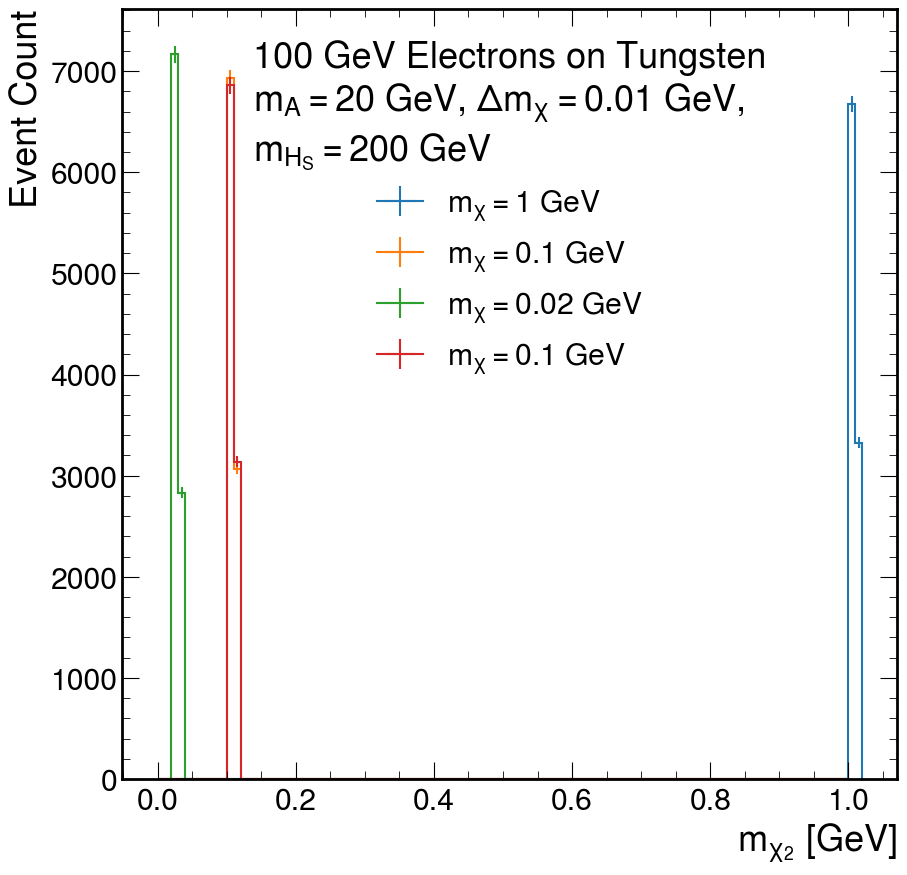

In [8]:
for name, (eventinfo, particles) in opts :
    hist.Hist(hist.axis.Regular(bins=100,start=0,stop=1,growth=True)).fill(
        ak.flatten(particles[(particles['id']==1000023)]['m'])
    ).plot(label=name)
plt.xlabel('$m_{\chi_2}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

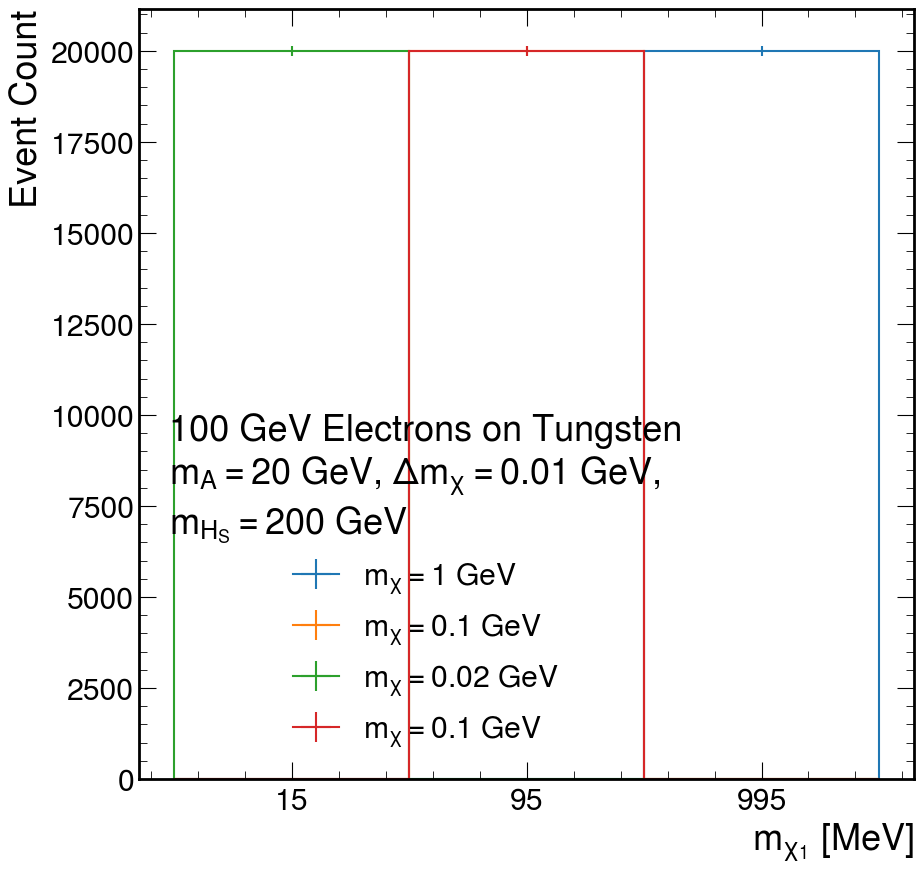

In [9]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.IntCategory([20-5,100-5,1000-5]))
    h.fill(ak.to_numpy(ak.flatten(particles[(particles['id']==1000022)]['m']*1000)).astype(int))
    h.plot(label=name)
plt.xlabel('$m_{\chi_1}$ [MeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

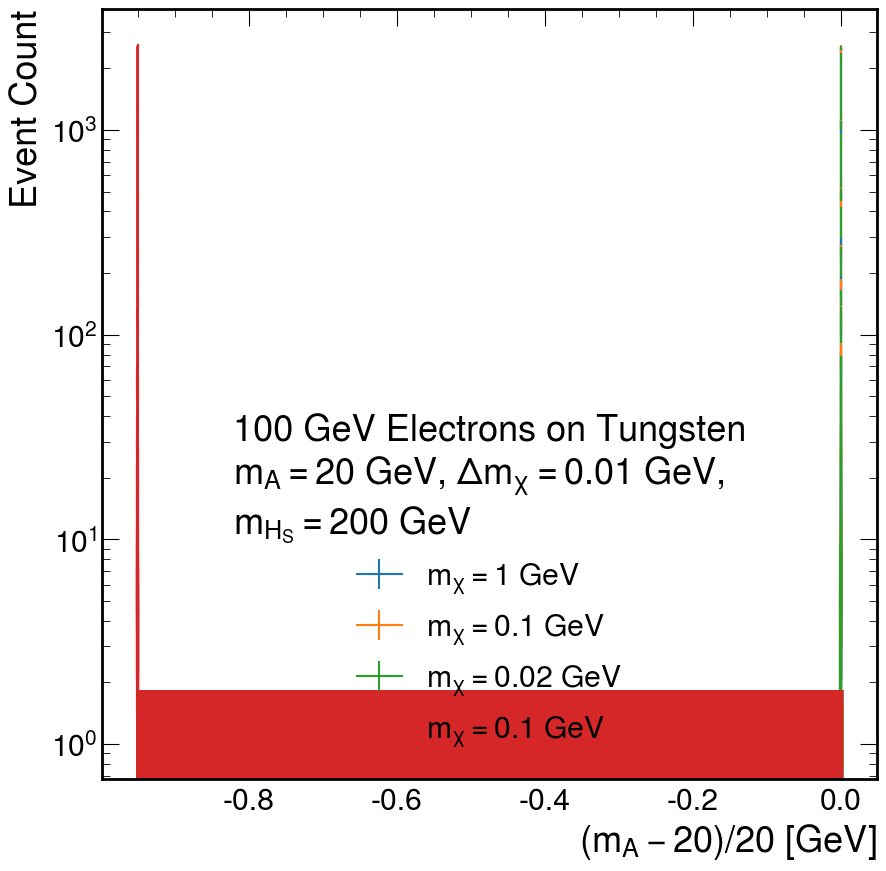

In [10]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-20))/20)
    h.plot(label=name)
plt.xlabel('$(m_{A}-20)/20$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

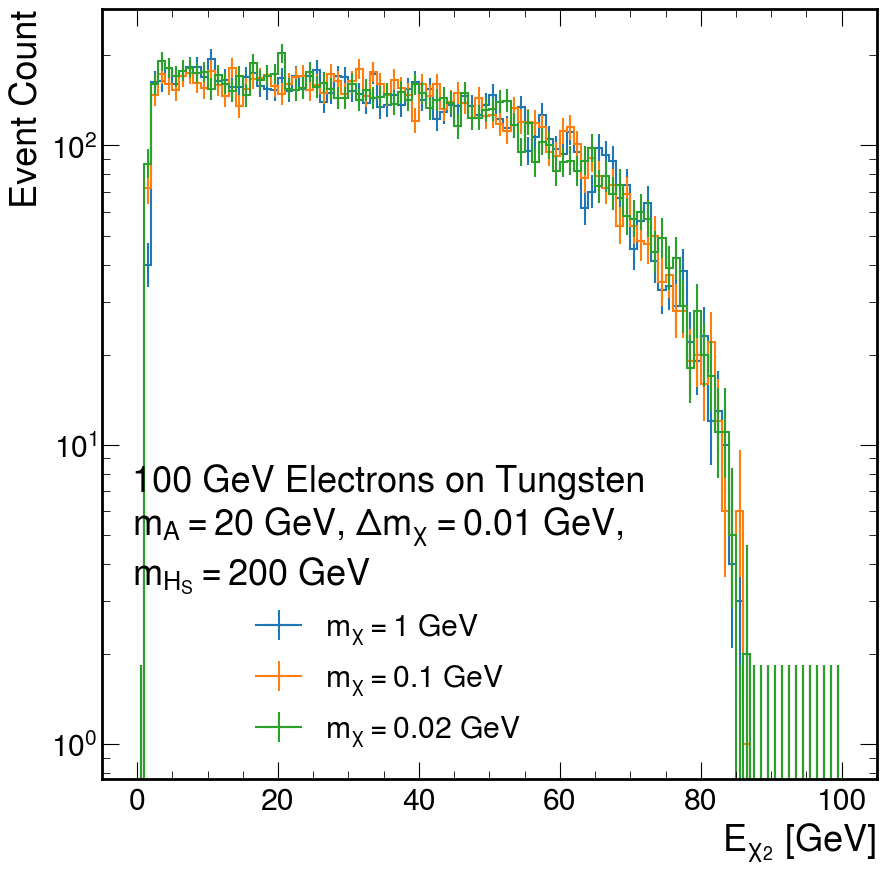

In [12]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,growth=True))
    h.fill(ak.flatten(particles[(particles['id']==1000023)]['vector']['t']))
    h.plot(label=name)
plt.xlabel('$E_{\chi_2}$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

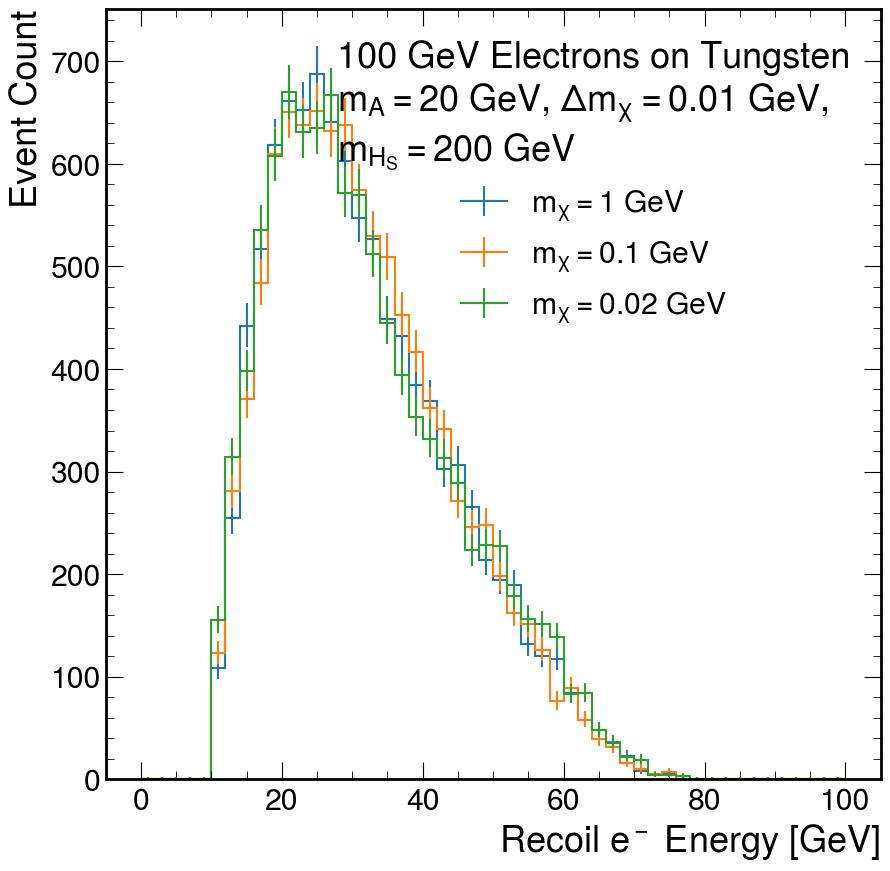

In [13]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=100, name='Recoil Electron Energy [GeV]'))
    h.fill(
        ak.flatten(
            particles[(particles['id']==+11)&(particles['status']==1)&(particles['mother2']==2)]['vector']['t']
        )
    )
    h.plot(label=name)
plt.xlabel('Recoil $e^-$ Energy [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.savefig('idm-recoil-electron-energy.pdf', bbox_inches='tight')
plt.show()

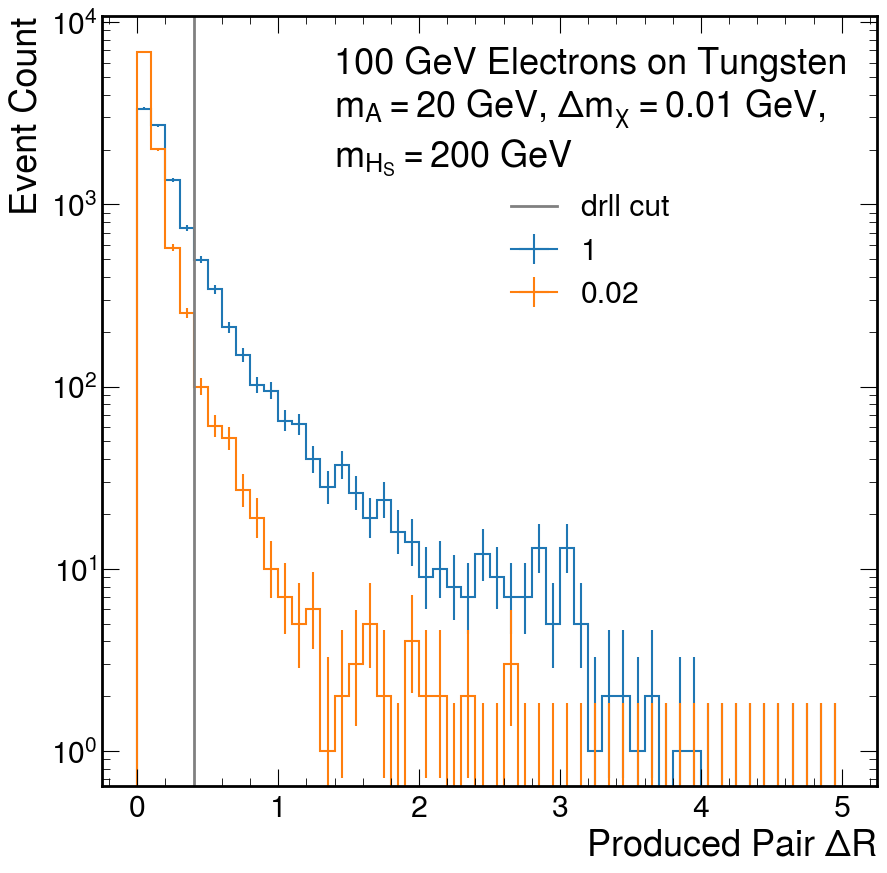

In [112]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5))
    prod_pos = ak.flatten(particles[(particles['id']==+11)&(particles['status']>0)&(particles['mother2']>2)]['vector'])
    prod_ele = ak.flatten(particles[(particles['id']==-11)&(particles['status']>0)&(particles['mother2']>2)]['vector'])
    h.fill(prod_pos.deltaR(prod_ele))
    h.plot(label=name)
plt.xlabel(f'Produced Pair $\Delta R$')
plt.ylabel('Event Count')
plt.yscale('log')
plt.axvline(0.4, color='gray', lw=2, label='drll cut')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
#plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
plt.show()

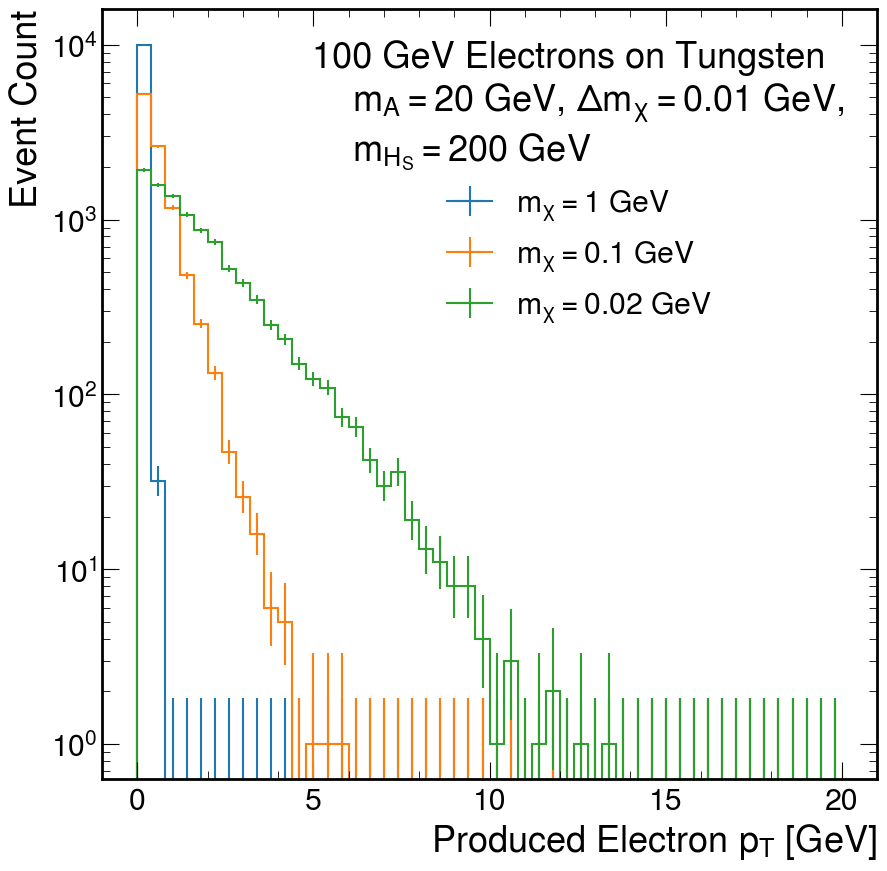

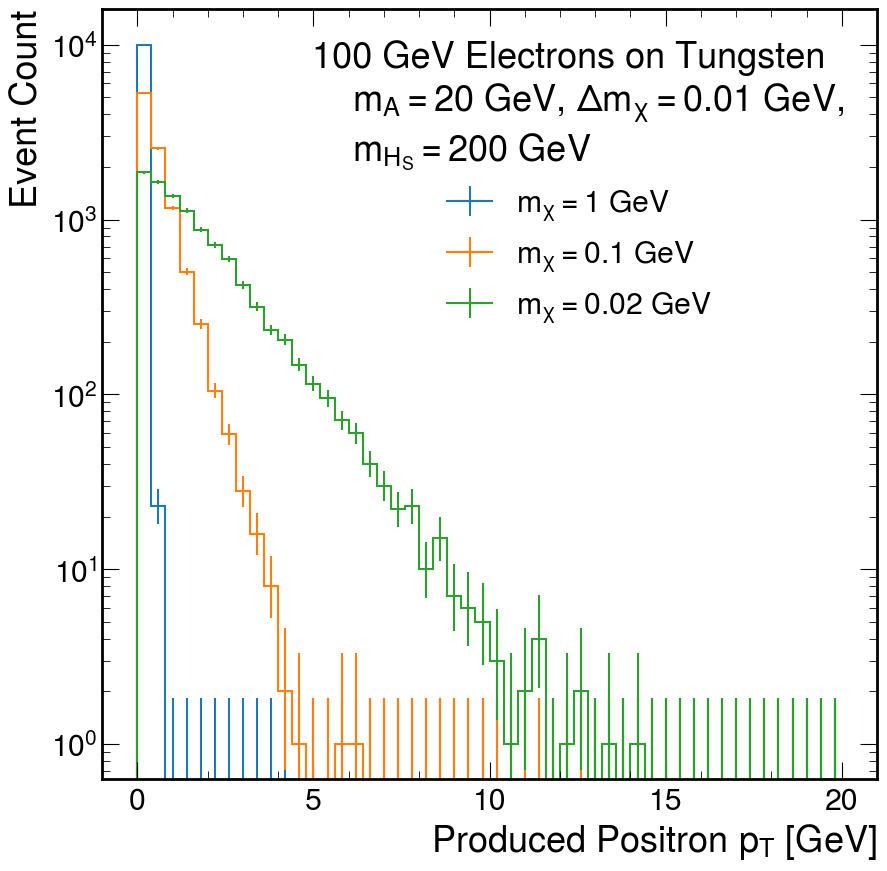

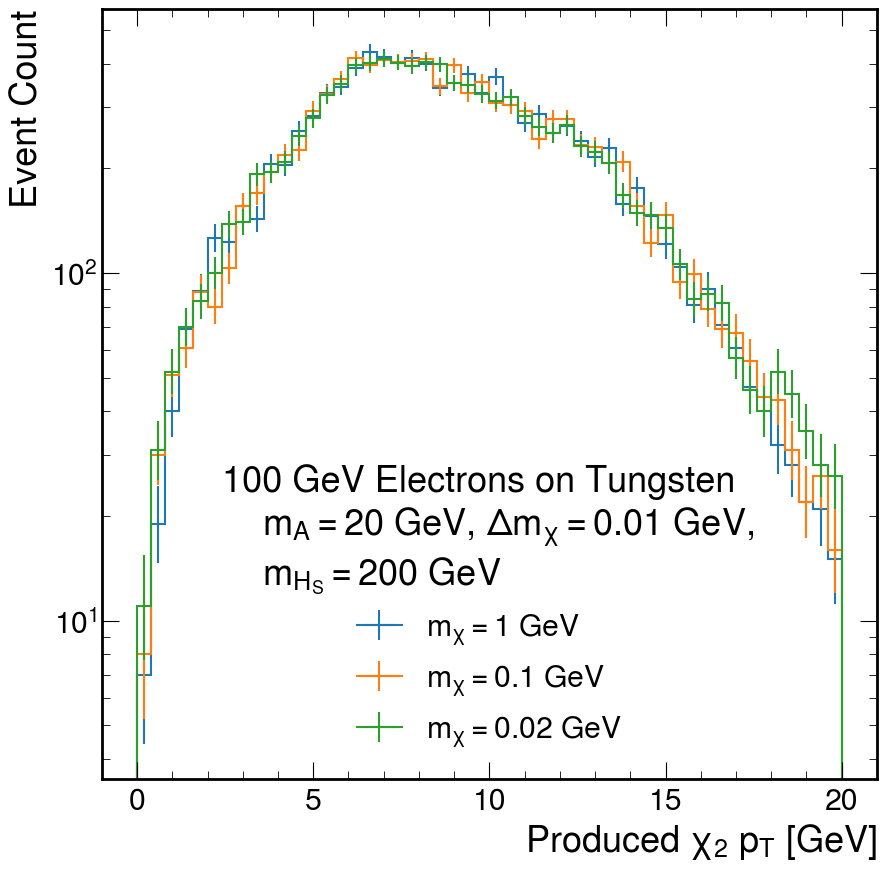

In [56]:
for p, pdg in [('Electron',11),('Positron',-11),(r'$\chi_2$',1000023)] :
    for name, (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=20, name=f'Produced {p} Energy [GeV]'))
        momentum = particles[(particles['id']==pdg)&(particles['status']>0)&(particles['mother2']>2)]['vector']
        h.fill(
            ak.flatten(momentum['x']**2 + momentum['y']**2)**0.5
        )
        h.plot(label=name)
    plt.xlabel(f'Produced {p} $p_T$ [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""100 GeV Electrons on Tungsten
    $m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
    $m_{H_S} = 200$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

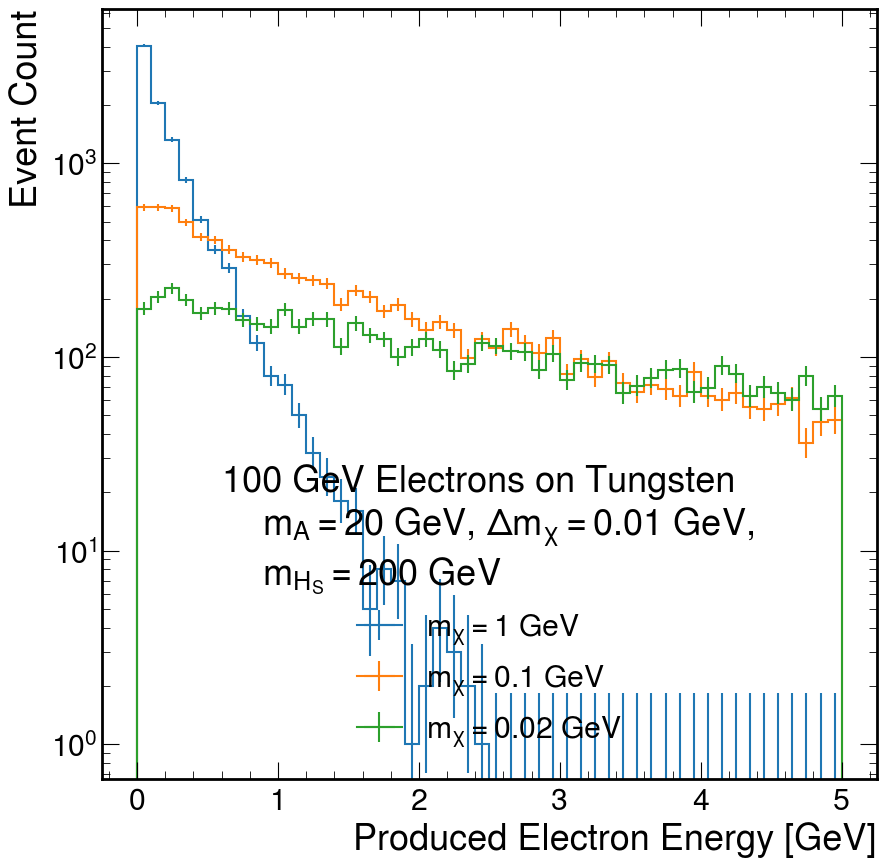

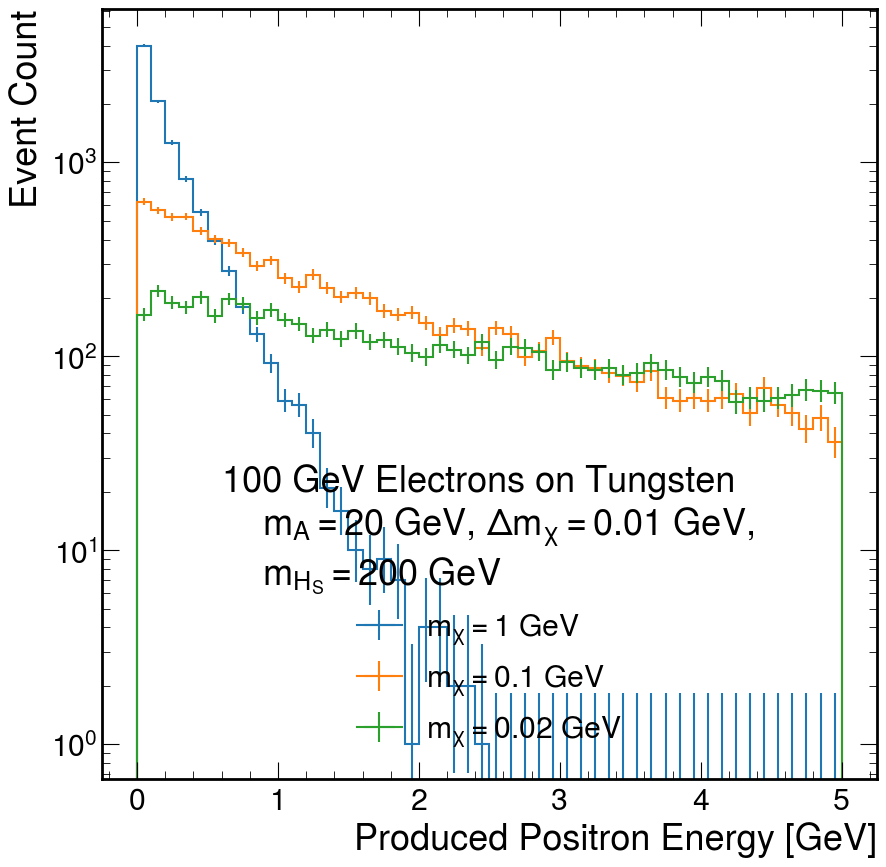

In [14]:
for p, pdg in [('Electron',11),('Positron',-11)] :
    for name, (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name=f'Produced {p} Energy [GeV]'))
        h.fill(
            ak.flatten(
                particles[(particles['id']==pdg)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            )
        )
        h.plot(label=name)
    plt.xlabel(f'Produced {p} Energy [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""100 GeV Electrons on Tungsten
    $m_A = 20$ GeV, $\Delta m_\chi = 0.01$ GeV, 
    $m_{H_S} = 200$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

## Lowering $m_A$
We also need to lower the dark photon mass so it is accessible by the HPS beam energy.

The main requirement is $m_A > 2 m_\chi$ so that the dark photon can still decay to $\chi_1 \chi_2$.

Lowering the dark photon to 2 GeV from 20 GeV immediately cut out phase space. Even with the beam energy at 100 GeV, MG only reported 2 events out of the 10k requested.

In [32]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    (20, ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    (2, ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_03/unweighted_events.lhe.gz'))),
]

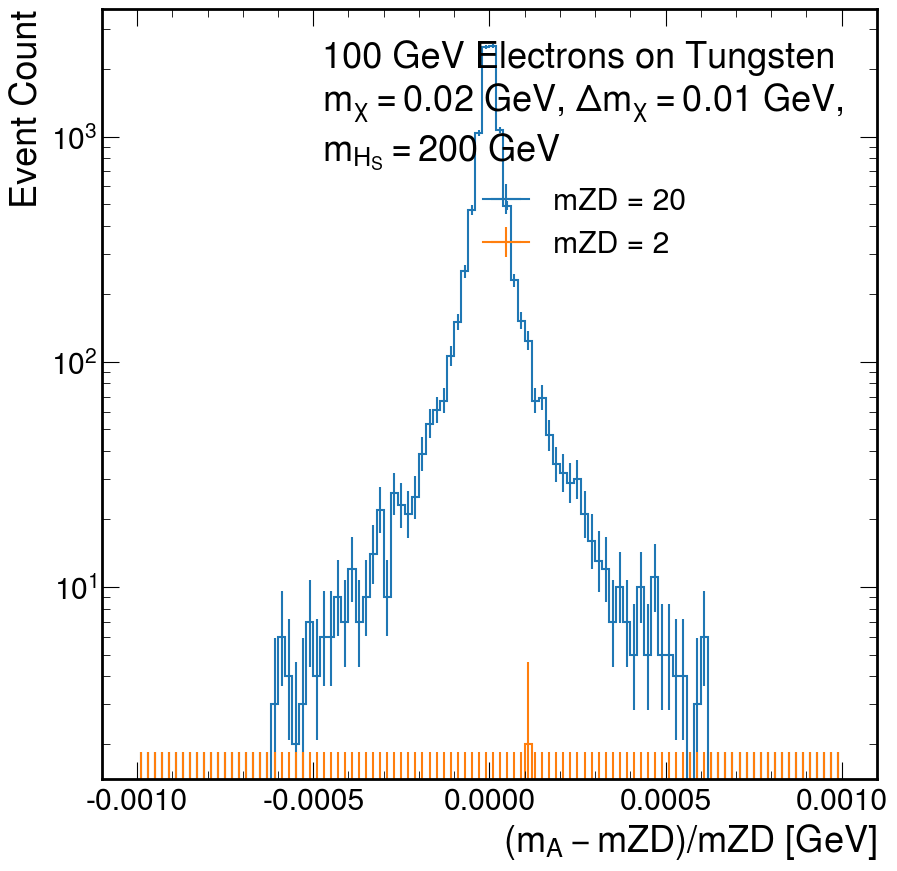

In [33]:
for mZD, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV, 
$m_{H_S} = 200$ GeV""")
plt.show()

## Lowering $m_{H_S}$
Since lowering `mZD` by itself seemed to close the phase space accessible, I am going to try to lower the other mass parameter `mHS` or what I understand as the mass of the dark higgs. Previously, it was left at 200 GeV but since `mZD` went down by an order of magnitude, I am going to try a run with `mHS` at 20.

In [39]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    ((20,200), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    ((2,20), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_04/unweighted_events.lhe.gz'))),
    ((2,10), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_05/unweighted_events.lhe.gz'))),
]

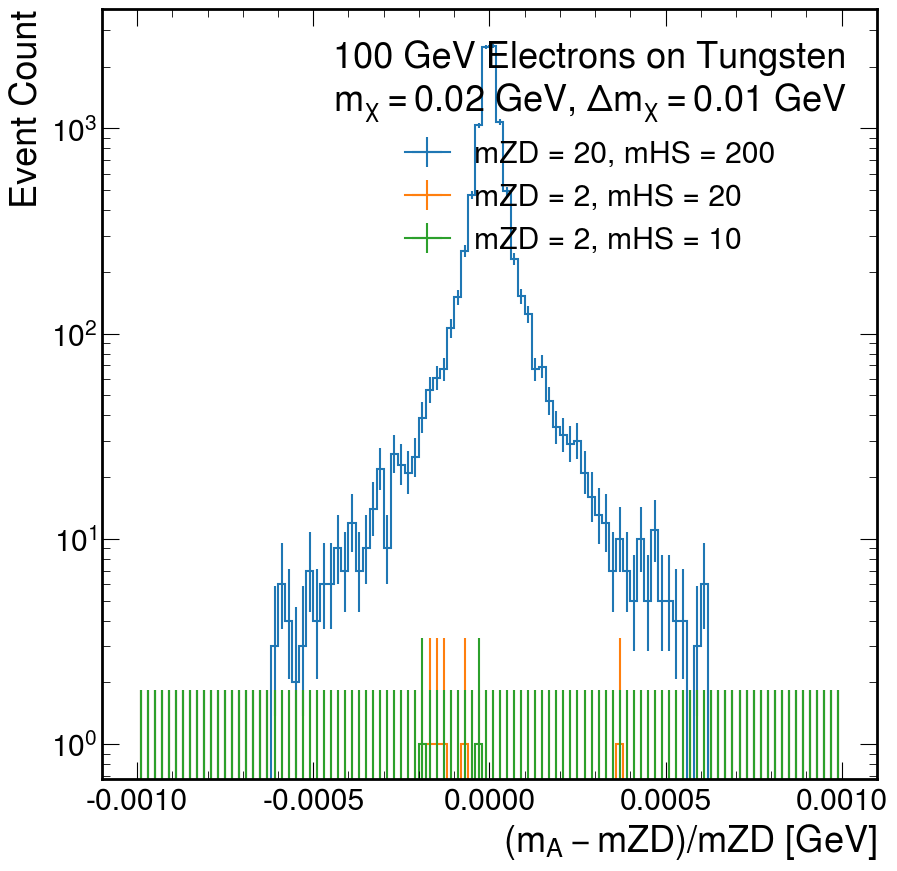

In [40]:
for (mZD,mHS), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}, mHS = {mHS}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV""")
plt.show()

## Changing `kap`

Try lowering `kap` as well but also try raising it since I think it is proportional to an interaction strength and we need to make the interaction stronger if we are running out of phase space.

In [45]:
# m_chi = 0.02 GeV, Delta m_chi = 0.01 GeV
opts = [
    ((20,200,1e-9), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_02/unweighted_events.lhe.gz'))),
    ((2,10,1e-11), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_06/unweighted_events.lhe.gz'))),
    ((2,10,1e-7), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_07/unweighted_events.lhe.gz'))),
]

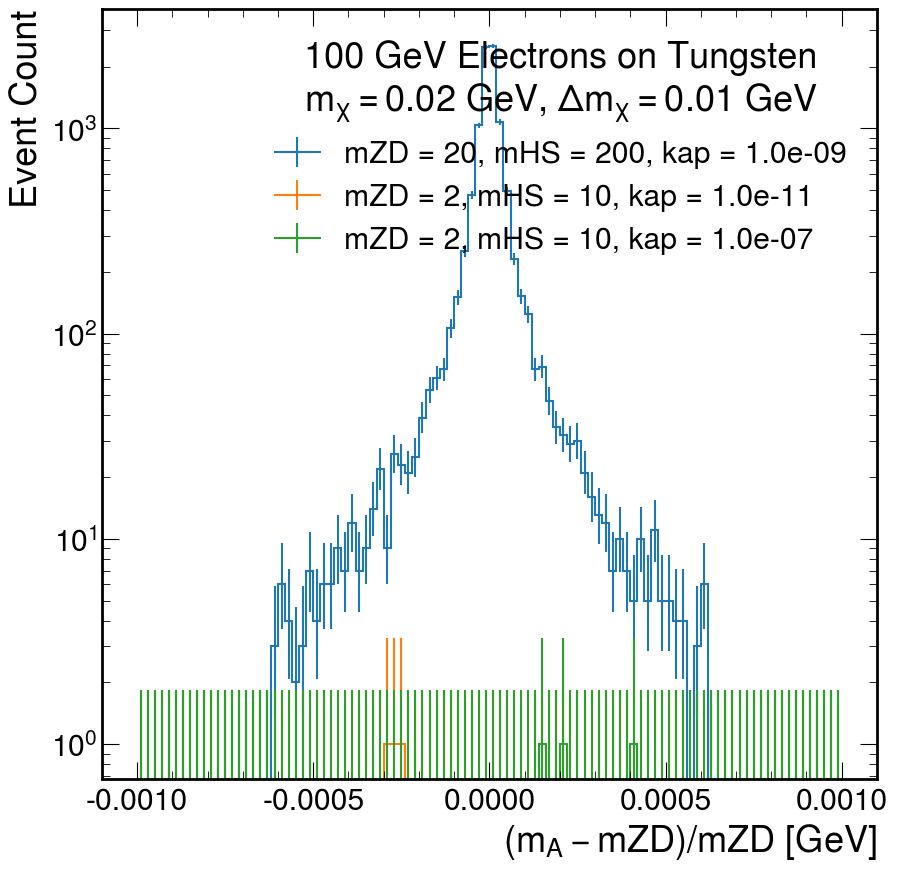

In [46]:
for (mZD,mHS,kap), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-3,stop=+1e-3,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZD)/mZD))
    h.plot(label=f'mZD = {mZD}, mHS = {mHS}, kap = {kap:.1e}')
plt.xlabel('$(m_{A} - mZD)/mZD$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""100 GeV Electrons on Tungsten
$m_\chi = 0.02$ GeV, $\Delta m_\chi = 0.01$ GeV""")
plt.show()

## Feedback from Ana Workshop
- Look for cut (looks like $E_{\chi_2}$ has a min energy cut)
- Lower `mZD` more to match ratio from defaults
- Lower `dMchi` more to match ratio from defaults

### Looking for Cuts
There are a lot of cuts in the default `run_card.dat` that I can remove one-by-one.
The following lists the run number and the cut removed relative `run_05`.

8. Set all listed minimums to `0.0` and listed maximums to `-1.0` (i.e. no cuts) => 10k events
    - I think, it is difficult to verify since the cuts listed in the header are the same as all previous runs ?!?
9. Remove `drll` minimum of `0.4`
10. 

In [22]:
opts = [
    ((1, 20, 200, 100), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-0-no-restrict/Events/run_01/unweighted_events.lhe.gz'))),
    ((0.02, 2, 10, 100), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-1-no-restrict/Events/run_08/unweighted_events.lhe'))),
    ((0.1, 1, 200, 2.3), ak.unzip(from_lhe('../MG5_aMC_v3_4_1/me-packs/idm-6-no-zpn-coupling/Events/run_01/unweighted_events.lhe.gz'))),
]

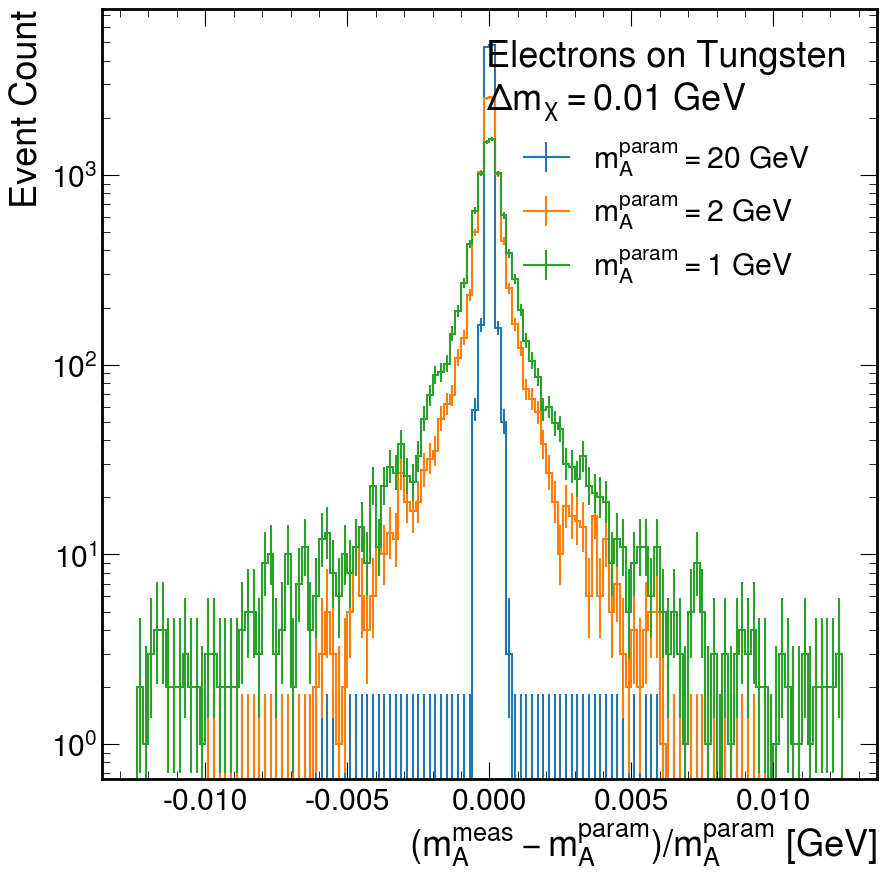

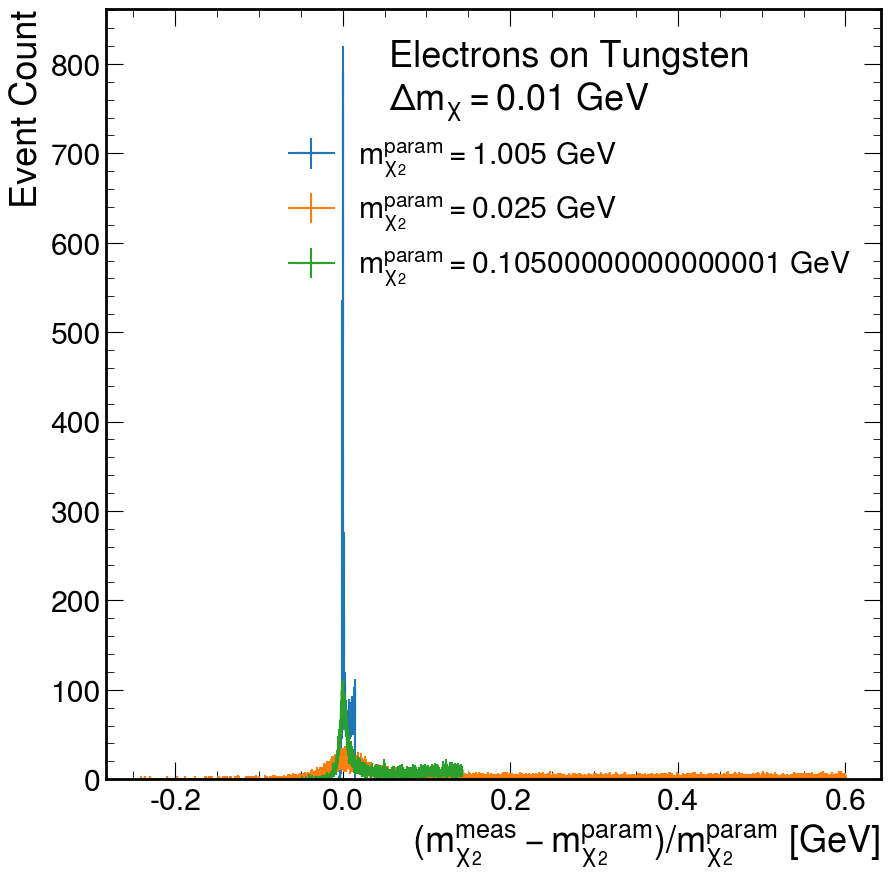

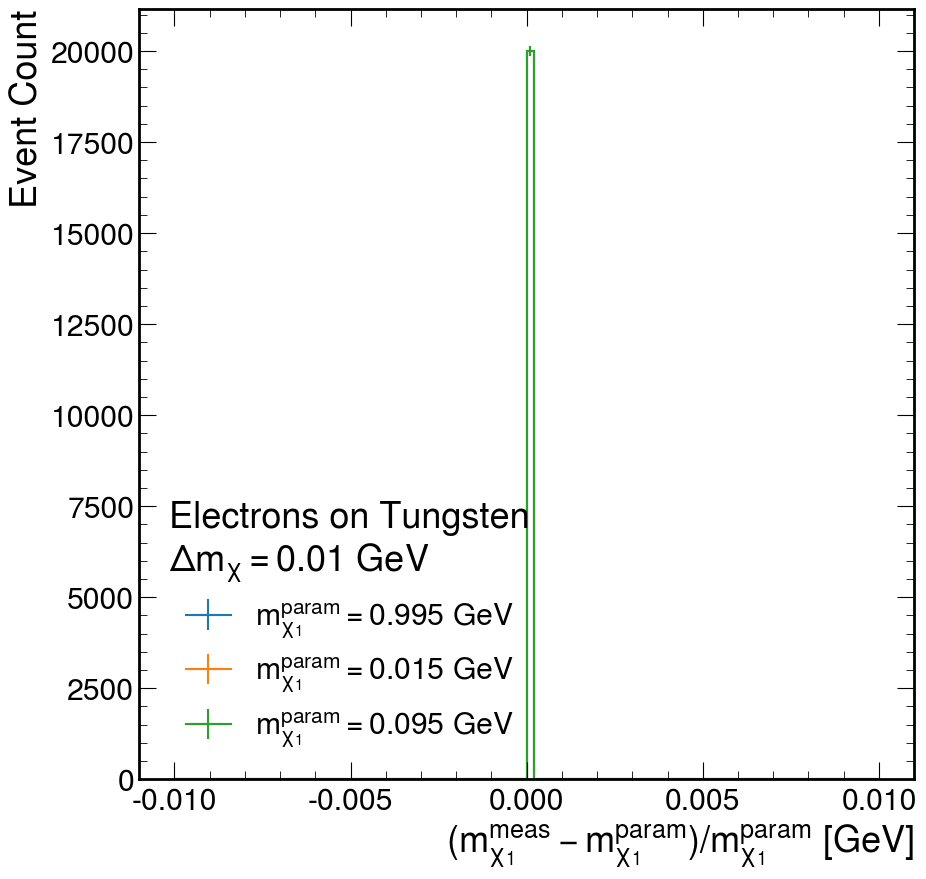

In [23]:
for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=+1e-2,growth=True))
    h.fill(ak.flatten((particles[(particles['id']==1023)]['m']-mZ)/mZ))
    h.plot(label='$m^{param}_{A} = '+f'{mZ}$ GeV')
plt.xlabel('$(m^{meas}_{A} - m^{param}_{A})/m^{param}_{A}$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

for (mC,mZ,mH,ebeam), (eventinfo, particles) in opts :
    param = (mC + 0.5 * 0.01)
    hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=1e-2,growth=True)).fill(
        ak.flatten((particles[(particles['id']==1000023)]['m']-param)/param)
    ).plot(label='$m^{param}_{\chi_2} = '+f'{param}$ GeV')
plt.xlabel('$(m^{meas}_{\chi_2} - m_{\chi_2}^{param})/m_{\chi_2}^{param}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

for (mC,mZ,mH,ebeam), (eventinfo, particles) in opts :
    param = (mC - 0.5 * 0.01)
    hist.Hist(hist.axis.Regular(bins=100,start=-1e-2,stop=1e-2,growth=True)).fill(
        ak.flatten((particles[(particles['id']==1000022)]['m']-param)/param)
    ).plot(label='$m^{param}_{\chi_1} = '+f'{param}$ GeV')
plt.xlabel('$(m^{meas}_{\chi_1} - m_{\chi_1}^{param})/m_{\chi_1}^{param}$ [GeV]')
plt.ylabel('Event Count')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
plt.show()

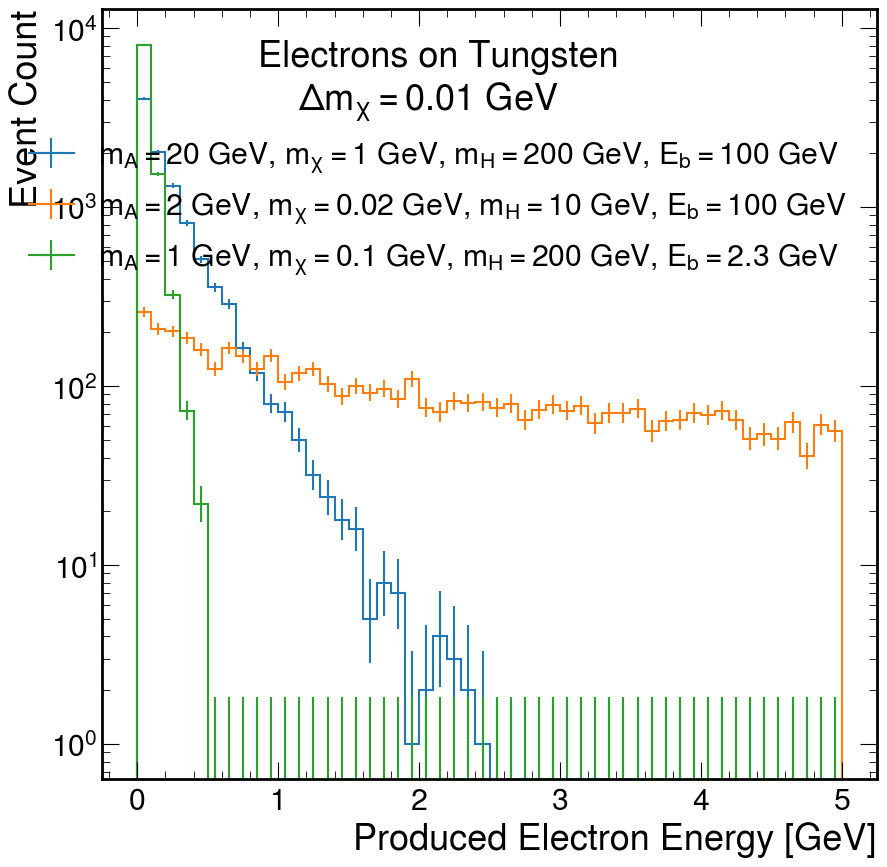

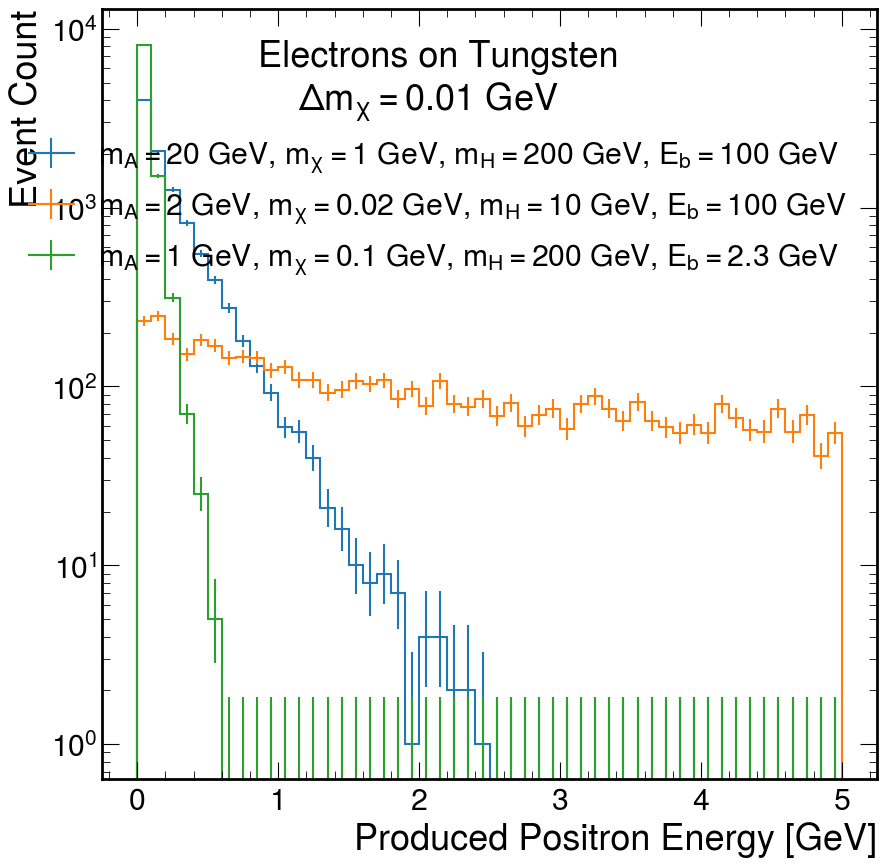

In [24]:
for p, pdg in [('Electron',11),('Positron',-11)] :
    for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
        h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name=f'Produced {p} Energy [GeV]'))
        h.fill(
            ak.flatten(
                particles[(particles['id']==pdg)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            )
        )
        h.plot(label=f'$m_A = {mZ}$ GeV, $m_\chi = {mC}$ GeV, $m_H = {mH}$ GeV, $E_b = {ebeam}$ GeV')
    plt.xlabel(f'Produced {p} Energy [GeV]')
    plt.ylabel('Event Count')
    plt.yscale('log')
    plt.legend(title="""Electrons on Tungsten
    $\Delta m_\chi = 0.01$ GeV""")
    #plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
    plt.show()

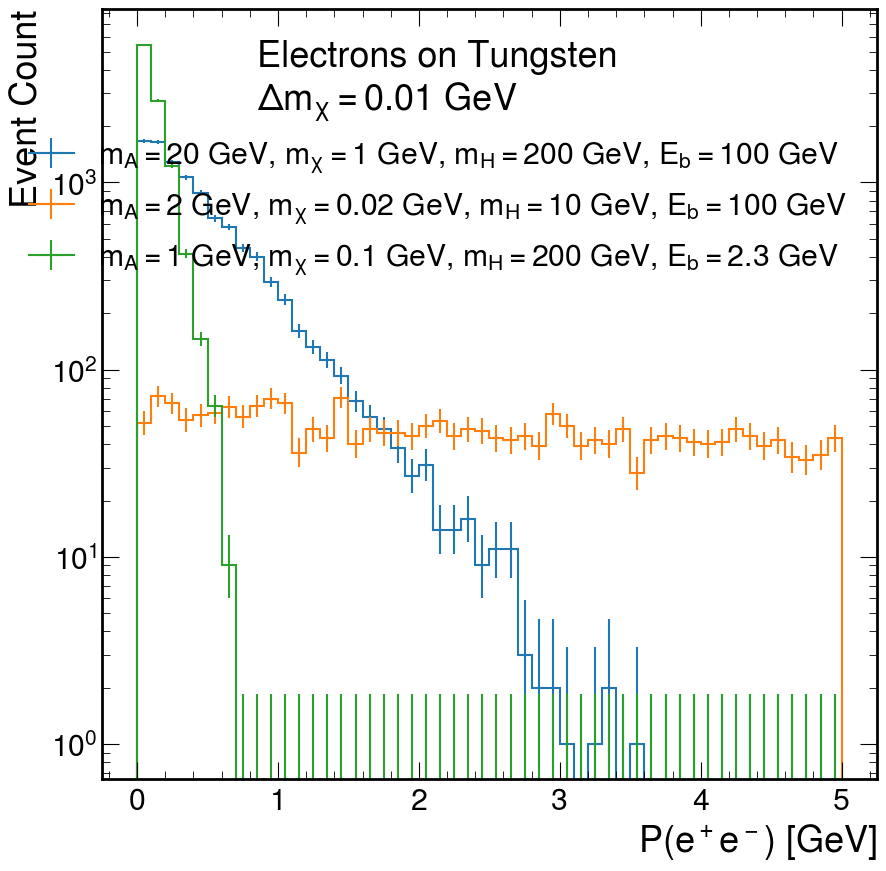

In [26]:
for (mC, mZ, mH, ebeam), (event_info, particles) in opts :
    hist.Hist(hist.axis.Regular(bins=50, start=0, stop=5, name='Esum')).fill(
        ak.flatten(
            particles[(particles['id']==-11)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
            + particles[(particles['id']==+11)&(particles['status']==1)&(particles['mother2']>2)]['vector']['t']
        )
    ).plot(label=f'$m_A = {mZ}$ GeV, $m_\chi = {mC}$ GeV, $m_H = {mH}$ GeV, $E_b = {ebeam}$ GeV')
plt.xlabel('$P(e^+e^-)$ [GeV]')
plt.ylabel('Event Count')
plt.yscale('log')
plt.legend(title="""Electrons on Tungsten
$\Delta m_\chi = 0.01$ GeV""")
#plt.savefig(f'idm-produced-{p.lower()}-energy.pdf', bbox_inches='tight')
plt.show()

# Generator Level
With the MG samples now in-hand, I can go through different parameters looking for things that we expect to pass the trigger cuts on the data.

We define "in acceptance" at the generator level as satisfying the criteria listed below.
1. Trigger Energy: $E_{e^-} > 150$ MeV and $E_{e^+} > 150$ MeV and $E_{e^-}+E_{e^+} > 600$ MeV
2. Angle Min: $\theta^{e^-}_{yz} > 0.015$ and $\theta^{e^+}_{yz} > 0.015$

In [3]:
from math import tan

def load_pair_momenta(f):
    """Load the produced e+e- pair momenta from the input file of MG events
    
    The produced e+e- pair can be retrieved using a combination of PDG ID
    ('id') and ancestor information ('mother1'). The produced pair have a
    ancestor from "late" in the event so making sure that 'mother1' is
    greater than 1 eliminates the primary electron and the recoil electron
    from consideration.
    """
    eventinfo, particles = ak.unzip(from_lhe(f))
    prod_ele = ak.flatten(particles[(particles['id']==+11)&(particles['mother1']>1)]['vector'])
    prod_pos = ak.flatten(particles[(particles['id']==-11)&(particles['mother1']>1)]['vector'])
    return prod_ele, prod_pos, eventinfo['weight']

def plt_pair_kinematics(
    samples,
    *,
    mchi = 100,
    rdmchi = 0.1,
    rmap = 3
):
    """Plot the combined kinematics of the pair
    
    If any of the keyword arguments are provided as a list,
    it can be the only one provided as a list and it must have
    the same number of entries as samples.
    
    Parameters
    ----------
    samples : List[ak.Array], ak.Array
        list of flattened awkward arrays of pair 4-momenta
        or a single such array
    mchi : float, List[float]
        value of mchi or list of such values
    rdmchi : float, List[float]
            value of rdmchi or list of such values
    rdmap : float, List[float]
            value of rdmap or list of such values
    """
    def islist(a):
        return isinstance(a, list)
    
    def plt_kin_hists(a, axes, *, label = None):
        """fill and plot histograms on appropriate axes"""
        ((e, m), (pt, pz)) = axes
        hist.Hist(
            hist.axis.Regular(50,0,1.0, name='Pair E [GeV]')
        ).fill(a.E).plot(ax=e)

        hist.Hist(
            hist.axis.Regular(50,0,0.1, name='Pair $p_T$ [GeV]')
        ).fill(a.pt).plot(ax=pt)

        hist.Hist(
            hist.axis.Regular(50,0,1.0, name='Pair $p_z$ [GeV]')
        ).fill(a.z).plot(ax=pz)

        hist.Hist(
            hist.axis.Regular(50,0,0.1, name='Pair Mass [GeV]')
        ).fill(a.mass).plot(ax=m, label=label)
        
    fig, ax = plt.subplots(
        ncols=2, nrows=2, sharey='row',
        gridspec_kw = dict(
            wspace = 0.05,
            hspace = 0.3
        )
    )

    for _ax in ax:
        _ax[0].set_ylabel('Events')
        _ax[0].set_yscale('log')

    
    if islist(samples):
        if islist(mchi) and not islist(rdmchi) and not islist(rmap):
            labels = mchi
            legend_title = '$m_\\chi$ [MeV]'
            fig.suptitle(
                '$m_{{A\'}} = {rmap}m_\\chi$, $\Delta = {rdmchi}m_\\chi$'.format(
                    rmap = rmap, rdmchi = rdmchi
                )
            )
        elif not islist(mchi) and islist(rdmchi) and not islist(rmap):
            labels = rdmchi
            legend_title = '$\Delta/m_\\chi$'
            fig.suptitle(
                '$m_{{A\'}} = {rmap}m_\\chi$, $m_\\chi = {mchi}$ MeV'.format(
                    rmap = rmap, mchi = mchi
                )
            )
        elif not islist(mchi) and not islist(rdmchi) and islist(rmap):
            labels = rmap
            legend_title = '$m_{A\'}/m_\\chi$'
            fig.suptitle(
                '$\Delta = {rdmchi}m_\\chi$, $m_\\chi = {mchi}$ MeV'.format(
                    rdmchi = rdmchi, mchi = mchi
                )
            )
        elif any(map(islist, [mchi, rdmchi, rmap])):
            raise ValueError('Cannot loop over more than one parameter.')
        else:
            raise ValueError('Must provide parameter to change along with sample listing.')
        
        if len(labels) != len(samples):
            raise ValueError('Number of labels does not match number of samples')
        
        for label, momentum in zip(labels, samples):
            plt_kin_hists(momentum, ax, label = label)
        
        fig.legend(
            title = legend_title,
            loc = 'upper left',
            bbox_to_anchor = (0.9, 1)
        )
    else:
        fig.suptitle(
            '$m_{{A\'}} = {rmap}m_\\chi$, $\Delta = {rdmchi}m_\\chi$, $m_\\chi = {mchi}$ MeV'.format(
                mchi = mchi, rdmchi = rdmchi, rmap = rmap
            )
        )
        plt_kin_hists(samples, ax)

    return fig

def plt_gen_acceptance(
    ele, pos, *, mchi = 100, rdmchi = 0.1, rmap = 3
):
    """Plot the generator-level acceptance variables
    
    Parameters
    ----------
    ele : ak.Array
        4-momentum of produced electron
    pos : ak.Array
        4-momentum of produced positron
    mchi : float
        value of mchi in this sample in MeV
    rdmchi : float
        vlaue of rdmchi in this sample
    rmap : float
        value of rmap in this sample
    """
    
    fig, ((E, _noop),(alltheta, trigtheta)) = plt.subplots(
        ncols=2, nrows=2,
        gridspec_kw = dict(
            wspace = 0.4,
            hspace = 0.4
        )
    )
    fig.suptitle(
        plt_gen_acceptance._title_template.format(
            mchi = mchi, rdmchi = rdmchi, rmap = rmap
        ),
        x=0.51, y=0.8,
        horizontalalignment='left'
    )
    fig.set_size_inches(16,12)

    _noop.axis('off')
    
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=0, stop=1000, 
            name='electron $E$ [MeV]',
        ),
        hist.axis.Regular(
            bins=100,start=0,stop=1000,
            name='positron $E$ [MeV]',
        ),
    ).fill(
        ele.E*1000,
        pos.E*1000
    ).plot(
        cmin=1,
        norm=mpl.colors.LogNorm(),
        ax = E
    )
    E.collections[-1].colorbar.set_label('Events')
    E.plot(
        [ 150,      150, 600-150, 1000],
        [1000,  600-150,     150,  150],
        lw=2, color='tab:red'
    )
    
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=-1,stop=1, 
            name='electron $\\tan(\\theta_{yz}) \\sim p_y/p_z$',
        ),
        hist.axis.Regular(
            bins=100,start=-1,stop=1, 
            name='positron $\\tan(\\theta_{yz}) \\sim p_y/p_z$',
        ),
    ).fill(
        ele.y/ele.z,
        pos.y/pos.z
    ).plot(
        cmin=1,
        norm=mpl.colors.LogNorm(),
        ax = alltheta
    )
    alltheta.set_title('All Events')
    alltheta.collections[-1].colorbar.set_label('Events')
    alltheta.add_patch(mpl.patches.Rectangle(
        *plt_gen_acceptance._theta_rect,
        facecolor='tab:red', alpha=0.8
    ))

    # theta_yz passing energy cut
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=-1,stop=1, 
            name='electron $\\tan(\\theta_{yz}) \\sim p_y/p_z$',
        ),
        hist.axis.Regular(
            bins=100,start=-1,stop=1, 
            name='positron $\\tan(\\theta_{yz}) \\sim p_y/p_z$',
        ),
    ).fill(
        ele[(ele.E>0.15)&(pos.E>0.15)&(ele.E+pos.E>0.6)].y/ele[(ele.E>0.15)&(pos.E>0.15)&(ele.E+pos.E>0.6)].z,
        pos[(ele.E>0.15)&(pos.E>0.15)&(ele.E+pos.E>0.6)].y/pos[(ele.E>0.15)&(pos.E>0.15)&(ele.E+pos.E>0.6)].z
    ).plot(
        cmin=1,
        ax=trigtheta
        #norm=mpl.colors.LogNorm()
    )
    trigtheta.set_title('Passing Trig Energy')
    trigtheta.collections[-1].colorbar.set_label('Events')
    trigtheta.add_patch(mpl.patches.Rectangle(
        *plt_gen_acceptance._theta_rect,
        facecolor='tab:red', alpha=0.8
    ))
    
    return fig

plt_gen_acceptance._tan15 = tan(0.015)
plt_gen_acceptance._theta_rect = (
    (-plt_gen_acceptance._tan15, -plt_gen_acceptance._tan15),
    2*plt_gen_acceptance._tan15,
    2*plt_gen_acceptance._tan15
)

plt_gen_acceptance._title_template="""$m_{{A\'}} = {rmap}m_\\chi$
$\Delta = {rdmchi}m_\\chi$
$m_\\chi = {mchi}$ MeV
Red Line: Trigger Energy Cut
Reb Box: Angular Acceptance"""

## Scanning $m_\chi$
Using theoretically-motivated values for $m_{A'}$ and $\Delta$.

In [117]:
# just picking one run per mchi for now
samples = [
    ( 60, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_60/lhe/idm_2pt3_1.lhe')),
    ( 90, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_90/lhe/idm_2pt3_11.lhe')),
    (100, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_100/lhe/idm_2pt3_1.lhe')),
    (120, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_120/lhe/idm_2pt3_21.lhe')),
    (150, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_150/lhe/idm_2pt3_31.lhe')),
    (180, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_180/lhe/idm_2pt3_41.lhe')),
    (210, load_pair_momenta('../mc/examples/idm/output/HPS-PhysicsRun2016-Pass2/mchi_210/lhe/idm_2pt3_51.lhe')),
]

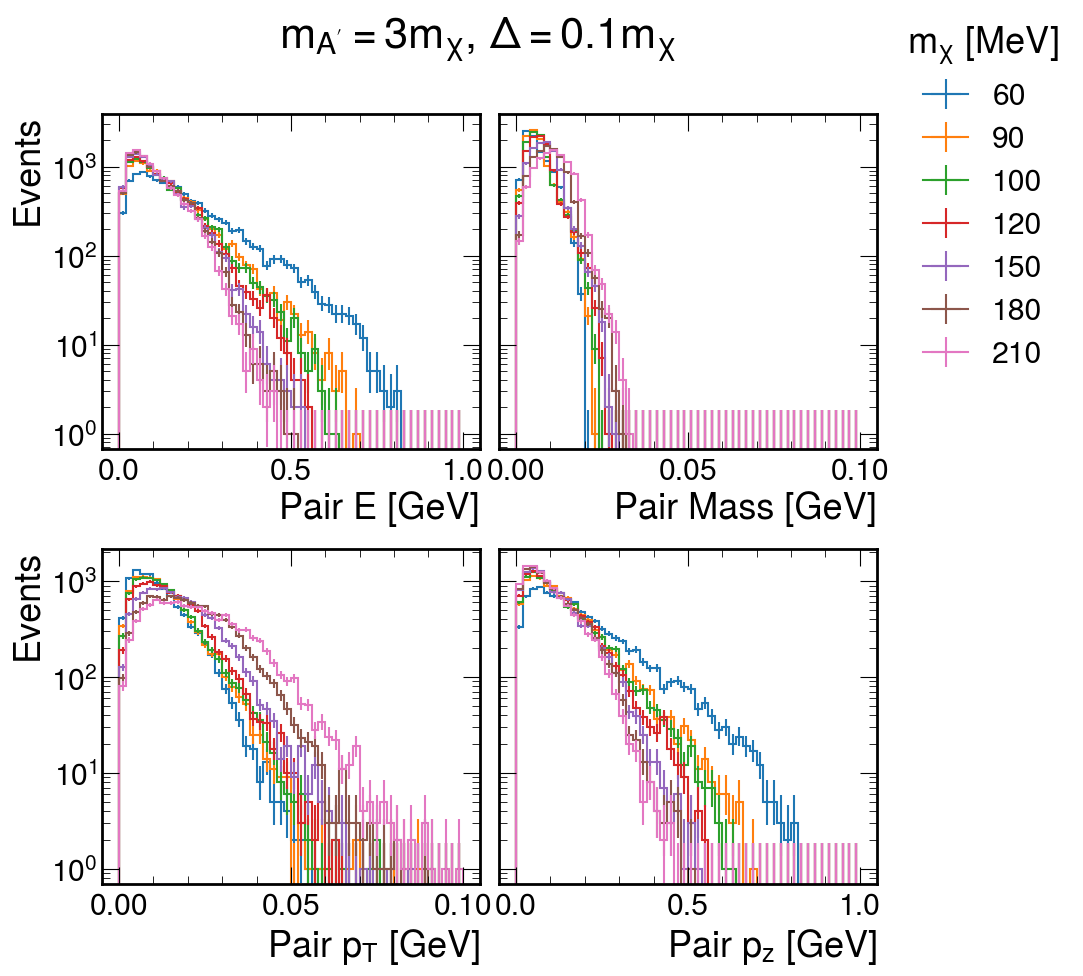

In [148]:
plt_pair_kinematics(
    [ele+pos for _, (ele, pos), _weight in samples],
    rdmchi = 0.1, rmap = 3,
    mchi = [m for m, _ in samples]
)
plt.show()

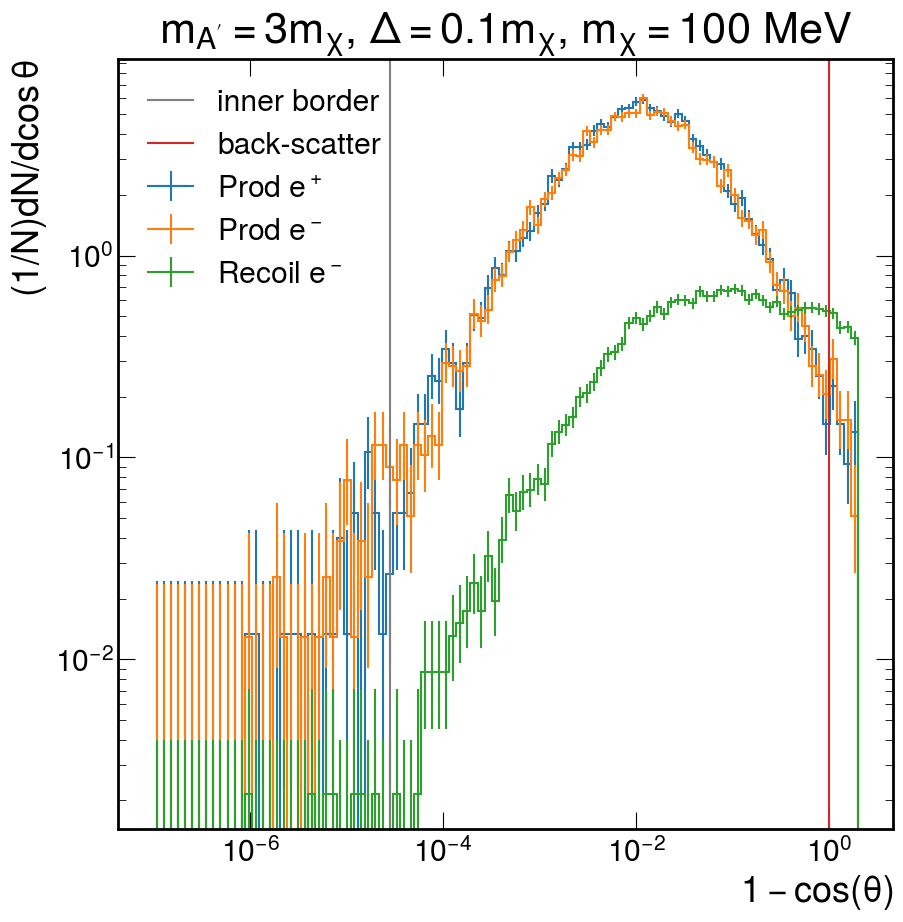

In [43]:
for name, selection in [
    ('Prod $e^+$',produced_pair&(particles['id']==-11)),
    ('Prod $e^-$',produced_pair&(particles['id']==+11)),
    ('Recoil $e^-$', (particles['id']==+11)&(particles['mother1']<2)),
]:
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=1e-7,stop=2, 
            name=f'$1-\cos(\\theta)$',
            transform=hist.axis.transform.log
        ),
    ).fill(
        ak.flatten(
            1-particles[selection]['vector'].costheta
        )
    ).plot(
        label=name,
        density=True
    )

plt.title('$m_{A\'}=3m_\\chi$, $\Delta=0.1m_\\chi$, $m_\\chi = 100$ MeV')
plt.yscale('log')
plt.xscale('log')
plt.axvline(1-cos(atan(1.5/200)), label='inner border', color='gray')
plt.axvline(1, label='back-scatter', color='tab:red')
plt.legend()
plt.ylabel('$(1/N)dN/d\cos\\theta$')
plt.show()

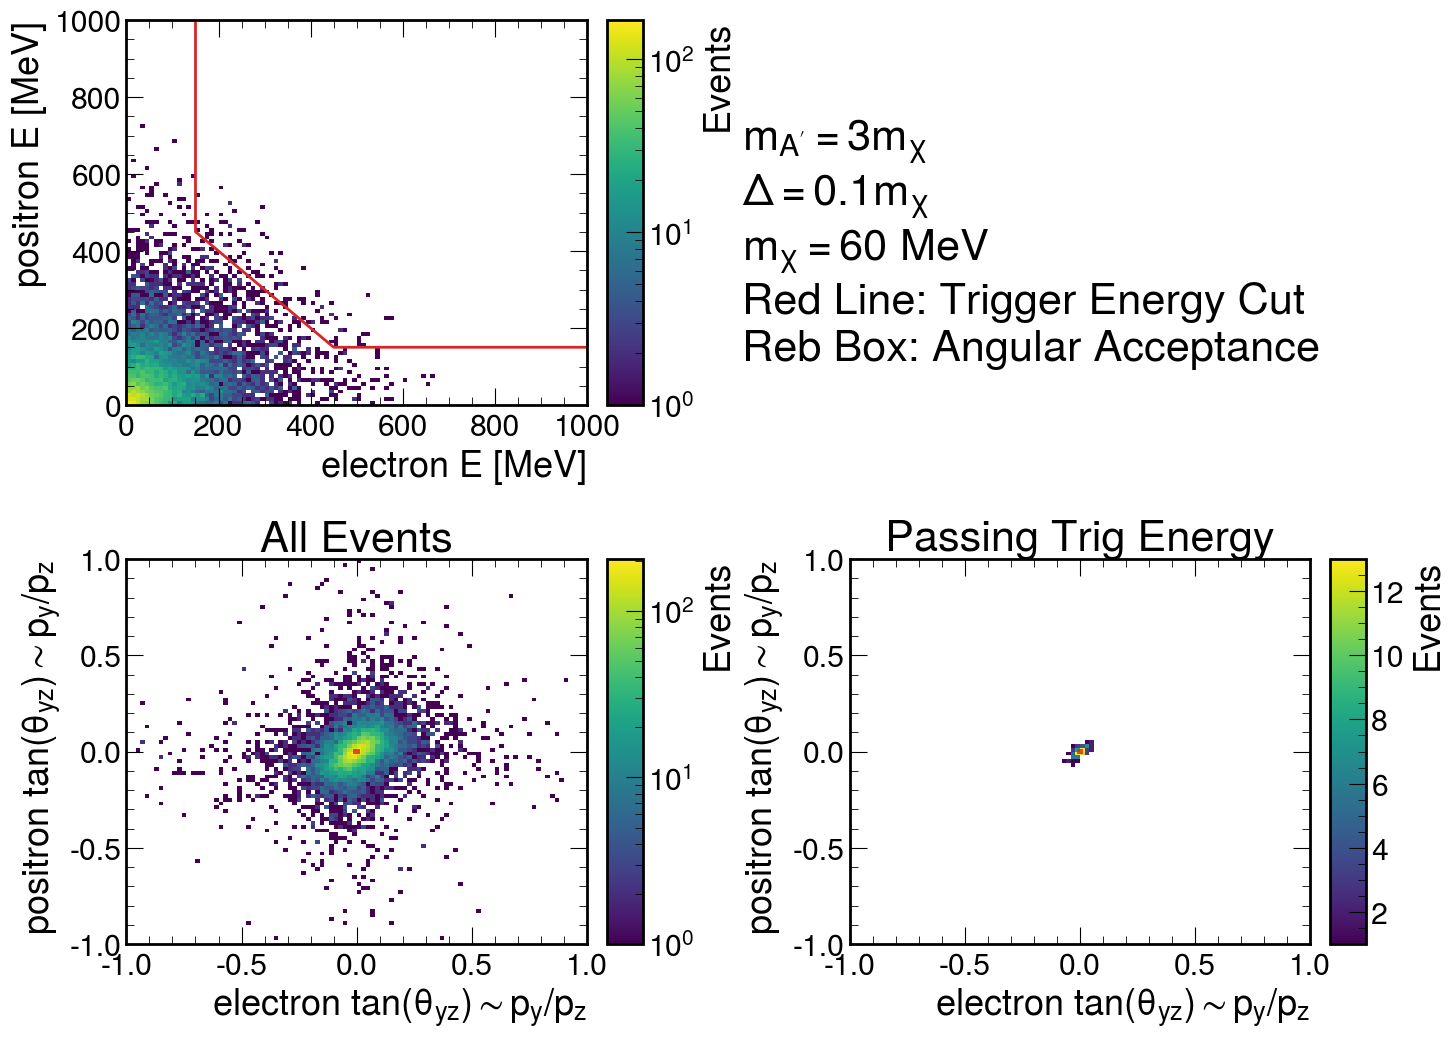

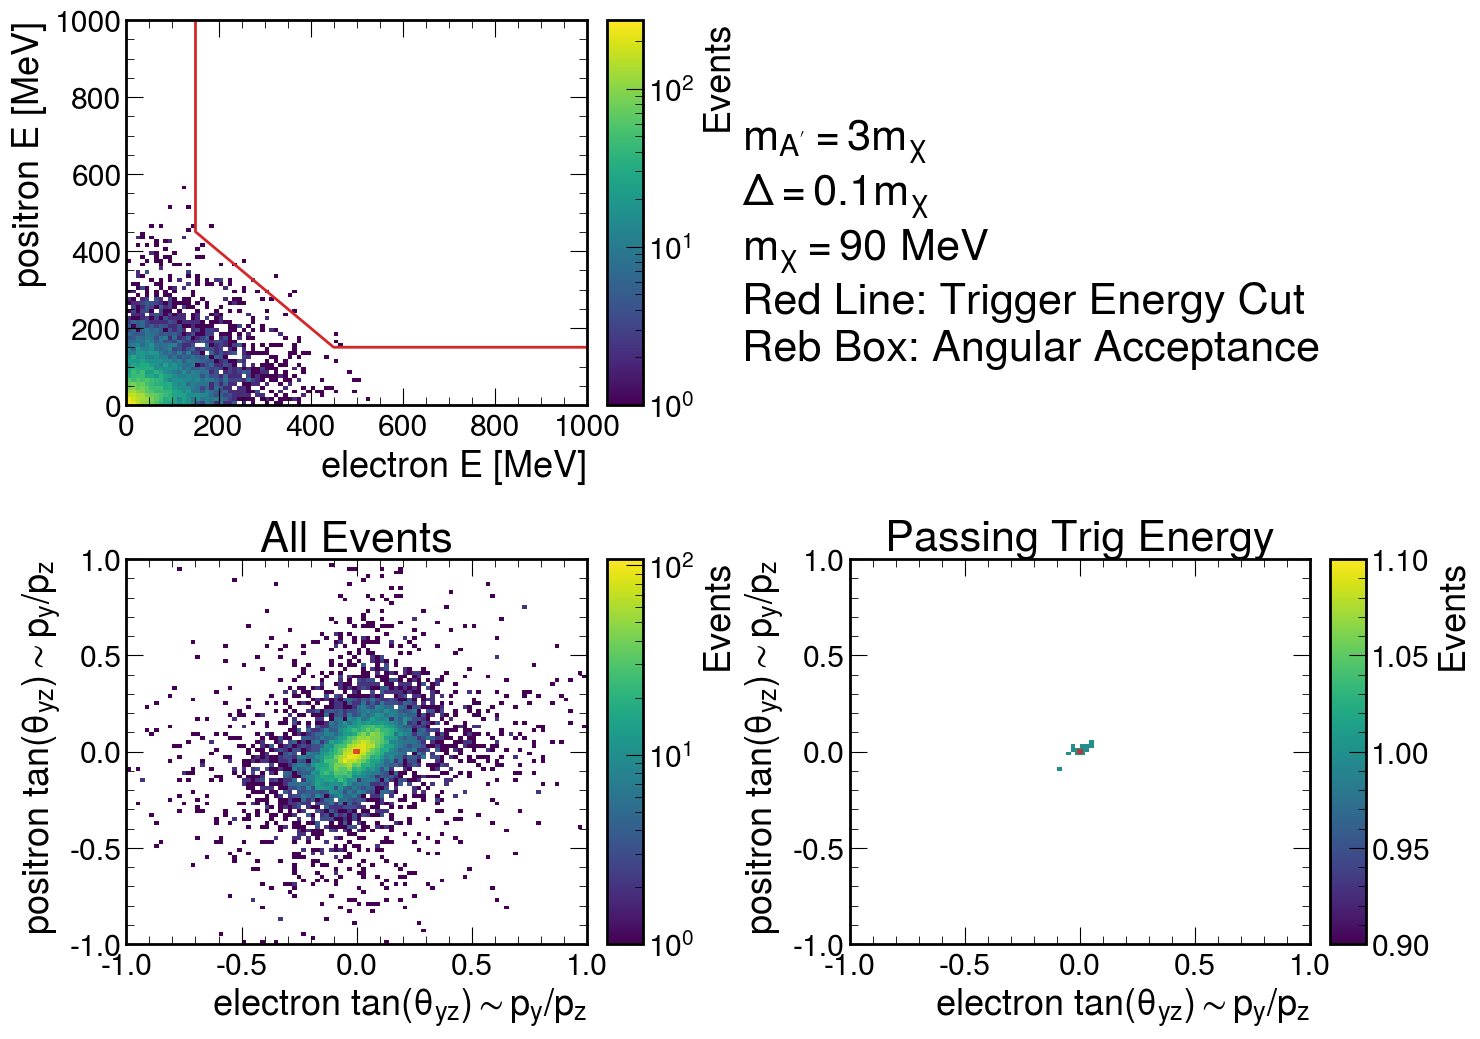

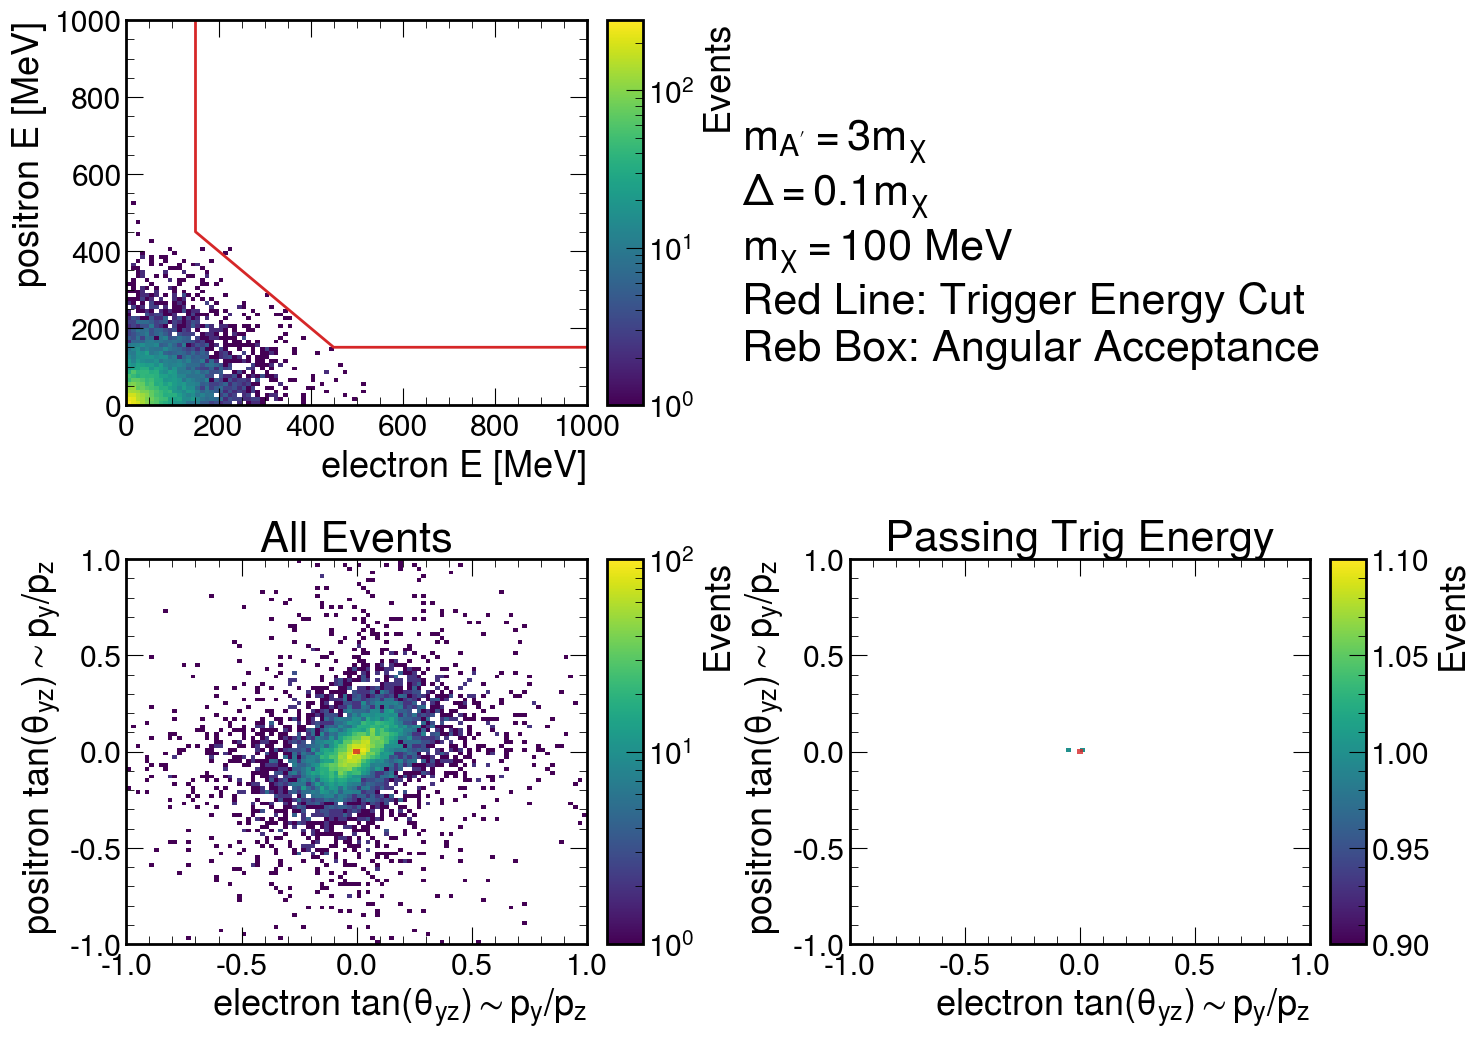

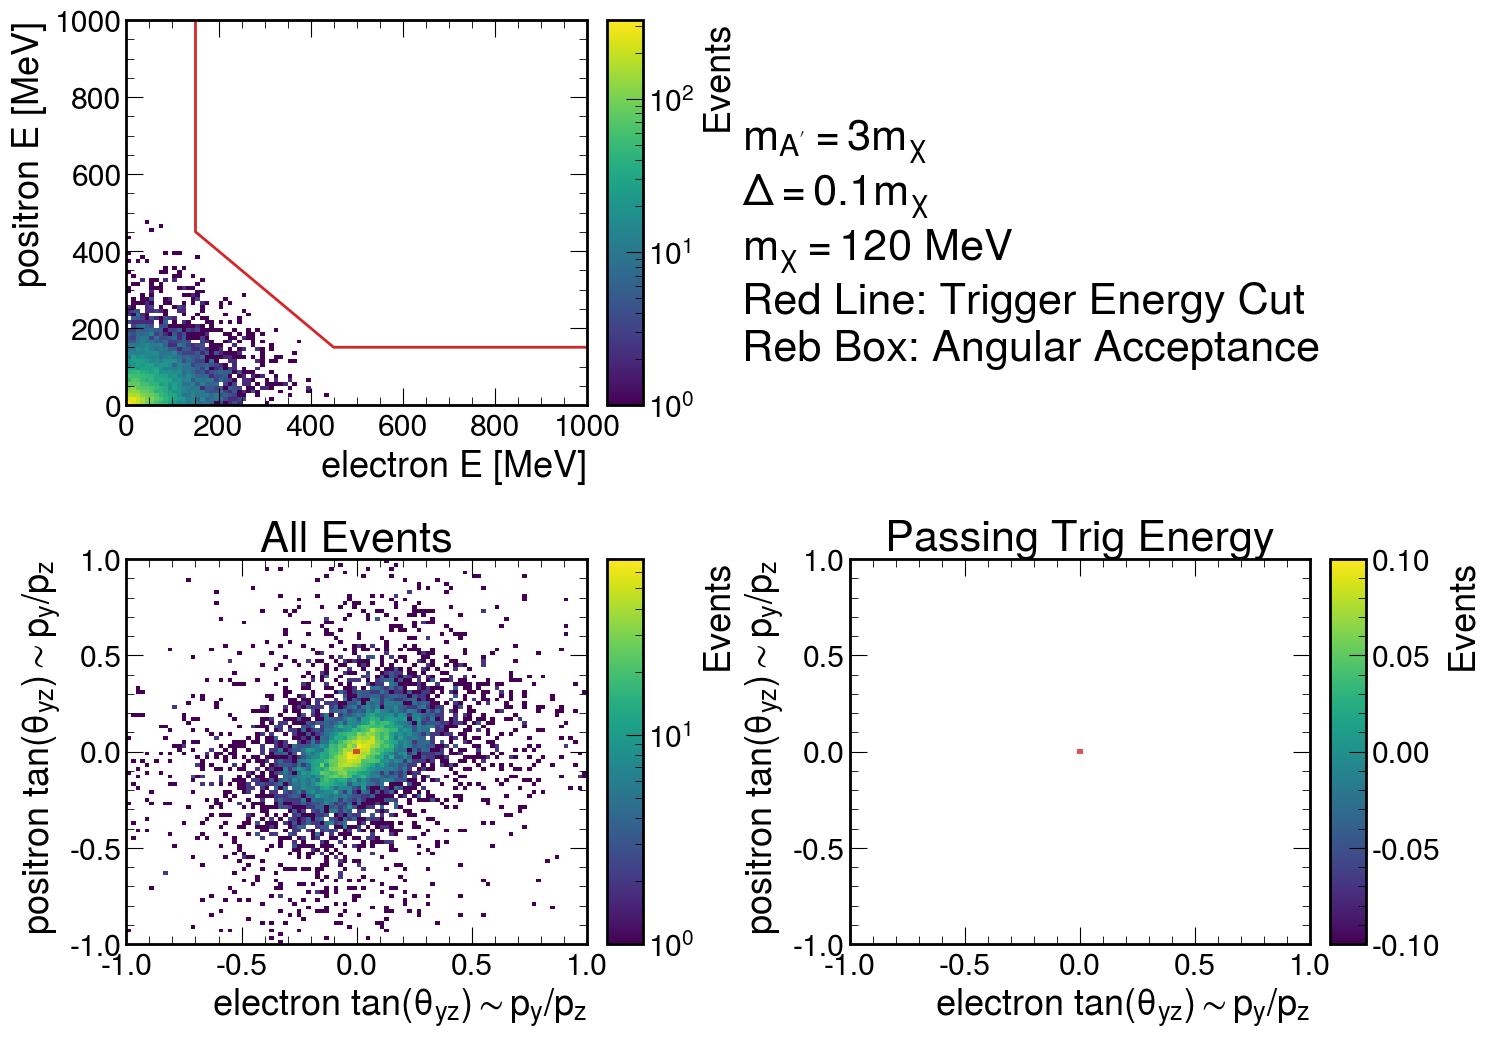

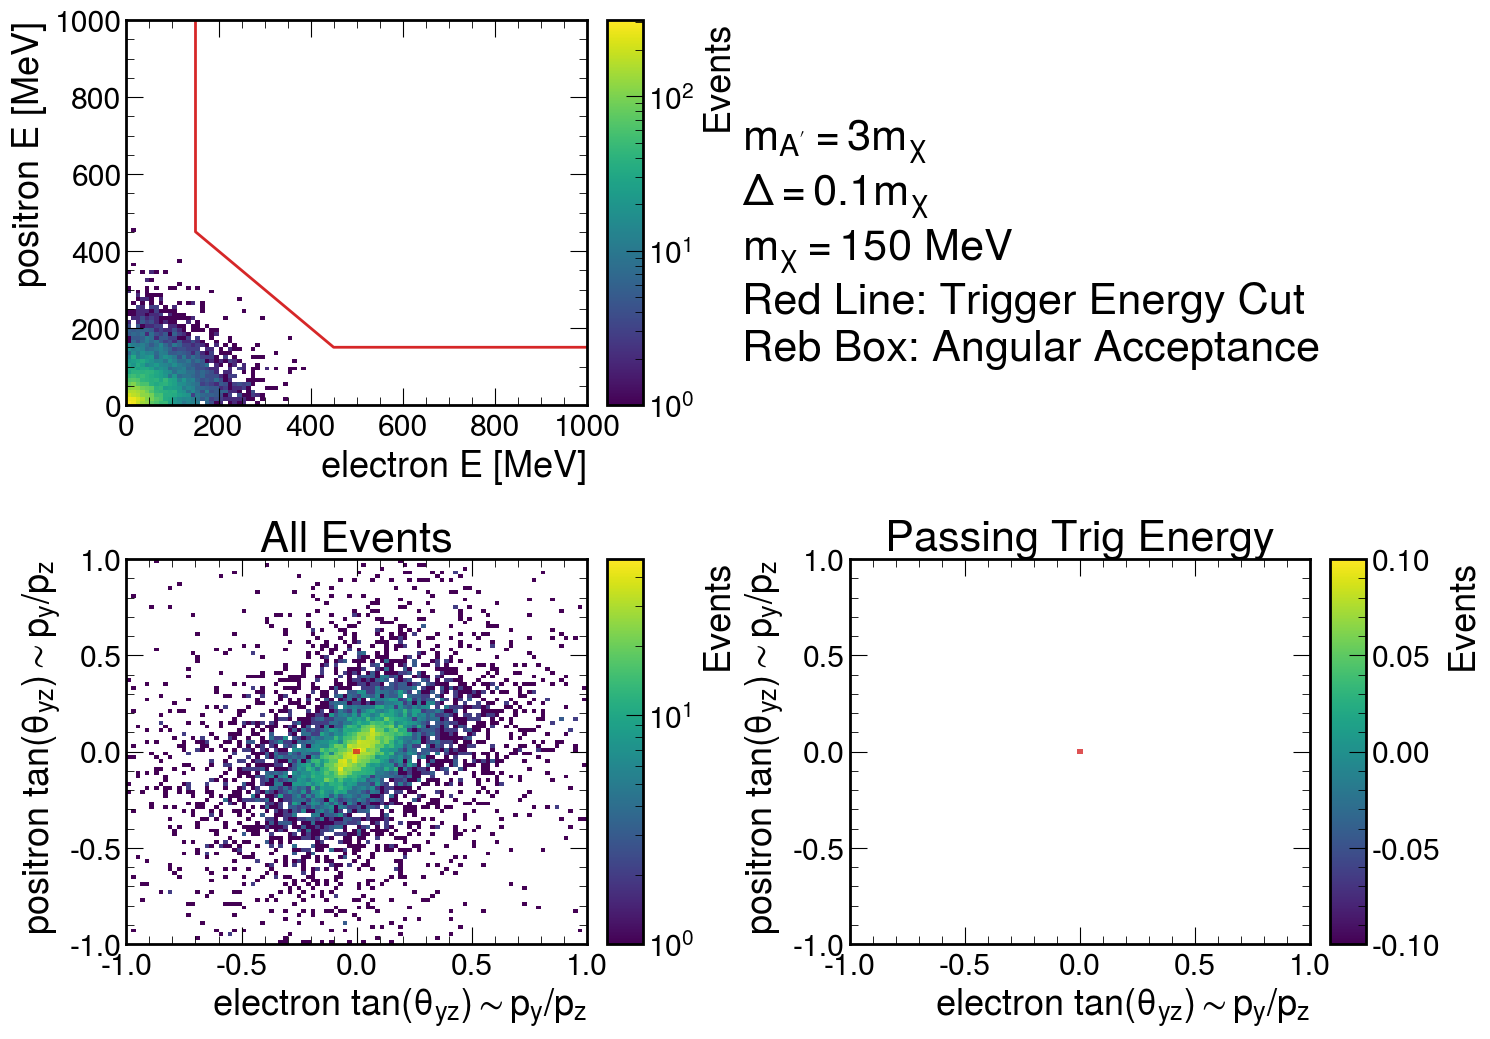

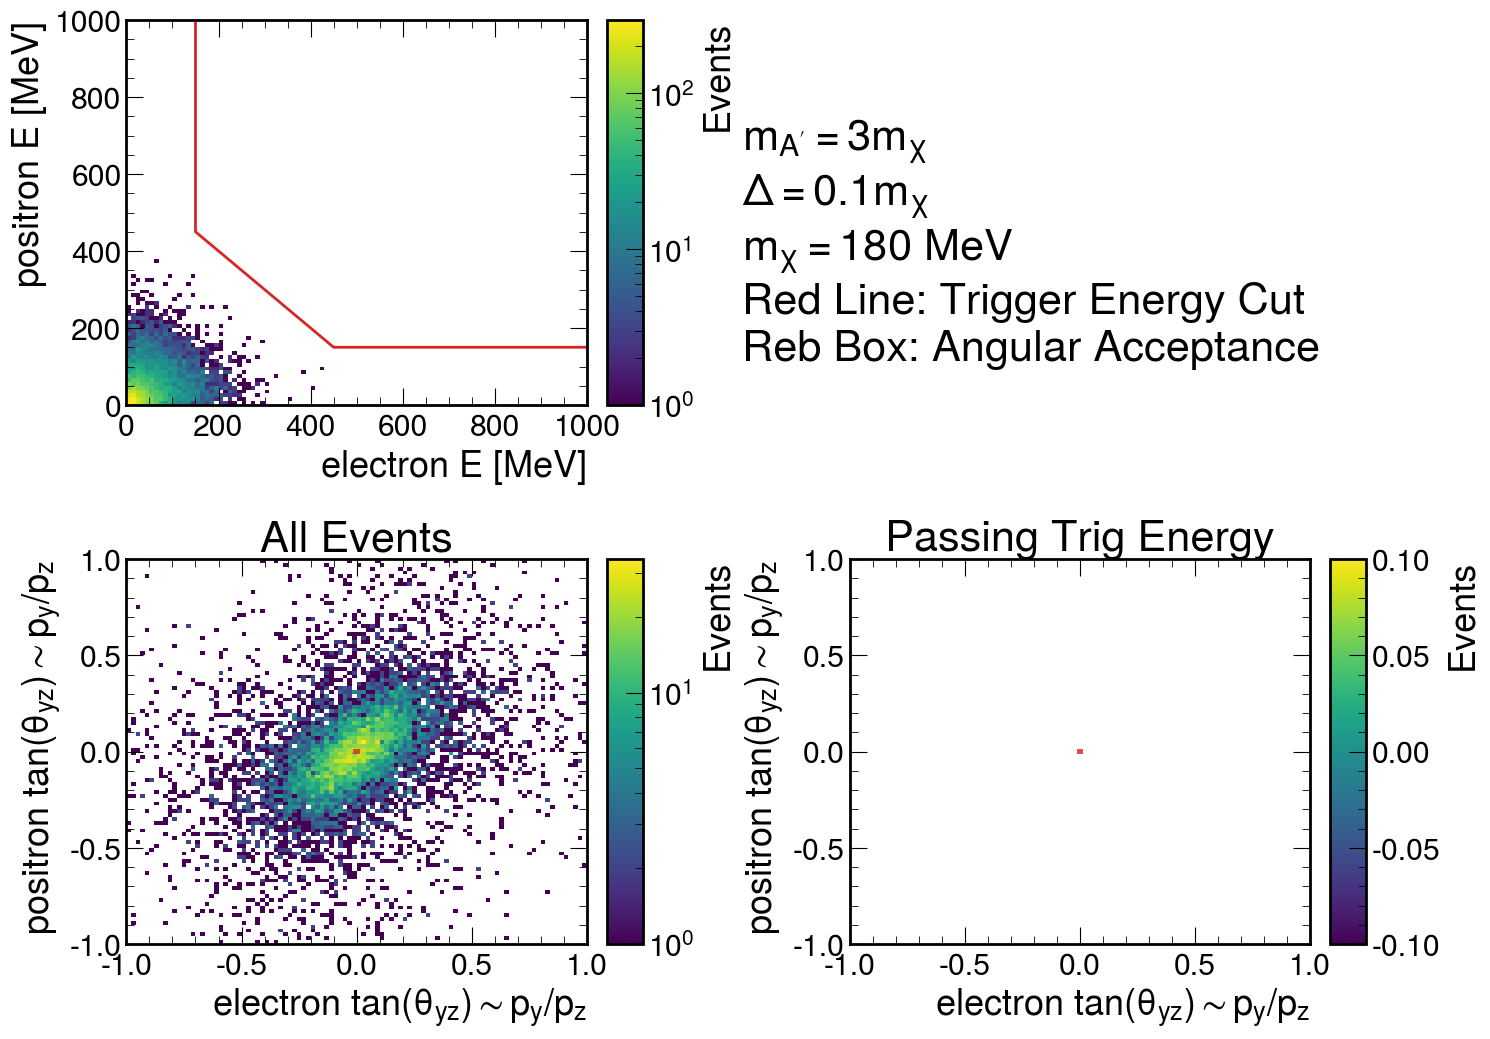

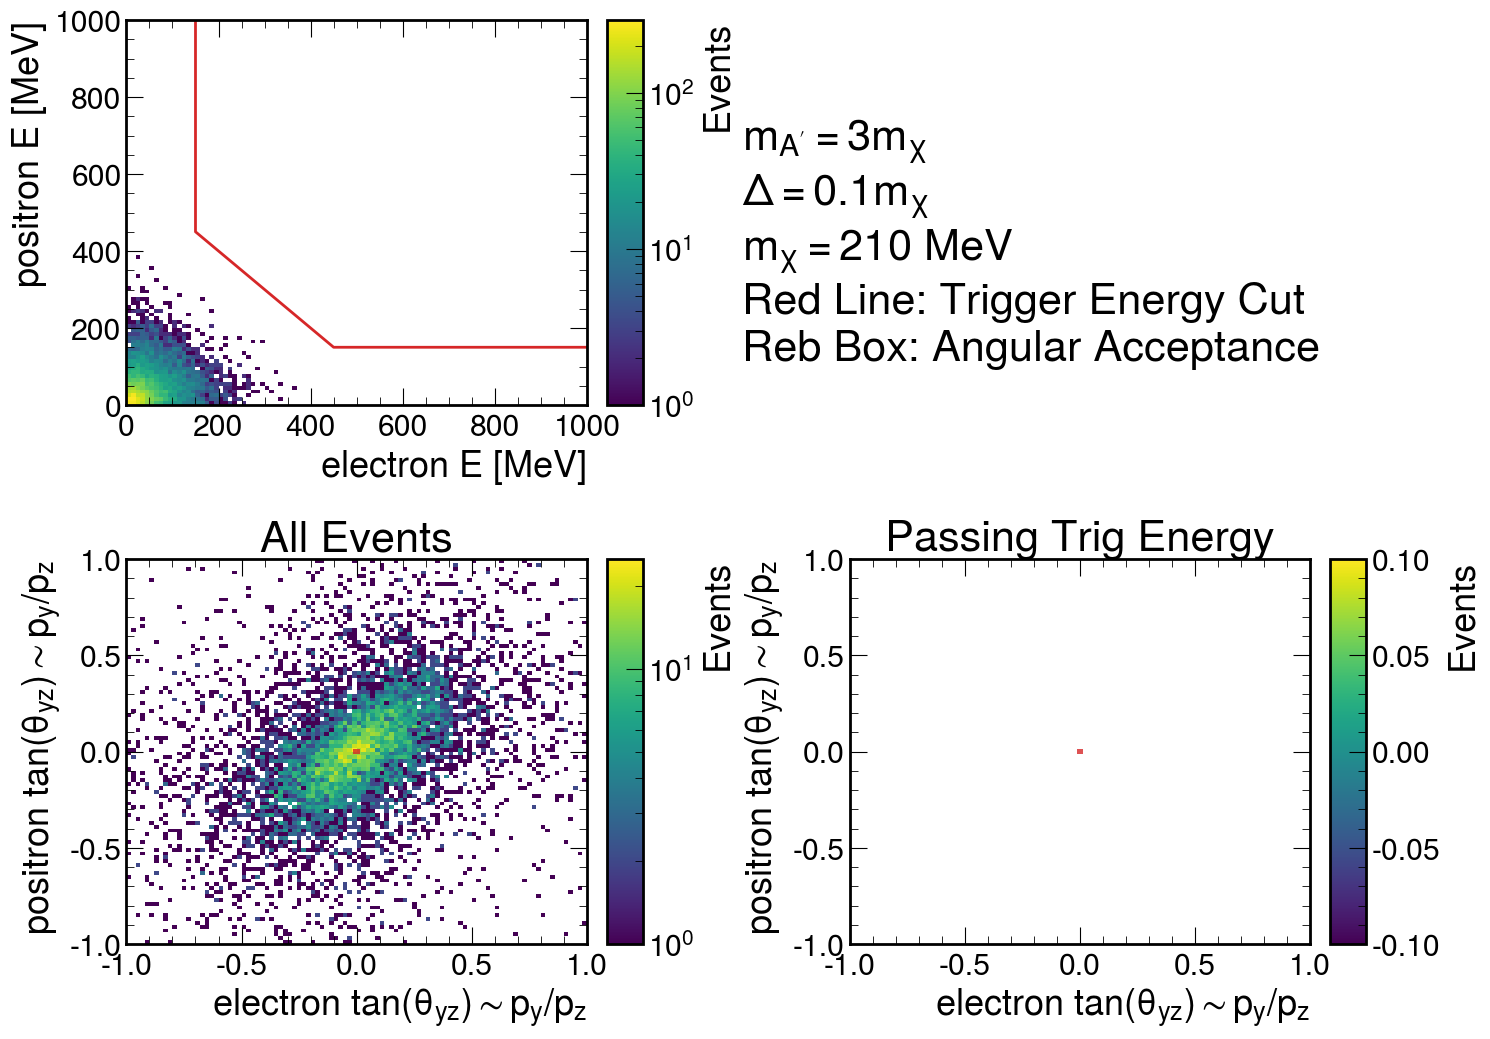

In [151]:
for mchi, (ele, pos), _weight in samples:
    fig = plt_gen_acceptance(ele, pos, mchi = mchi)
    plt.show()

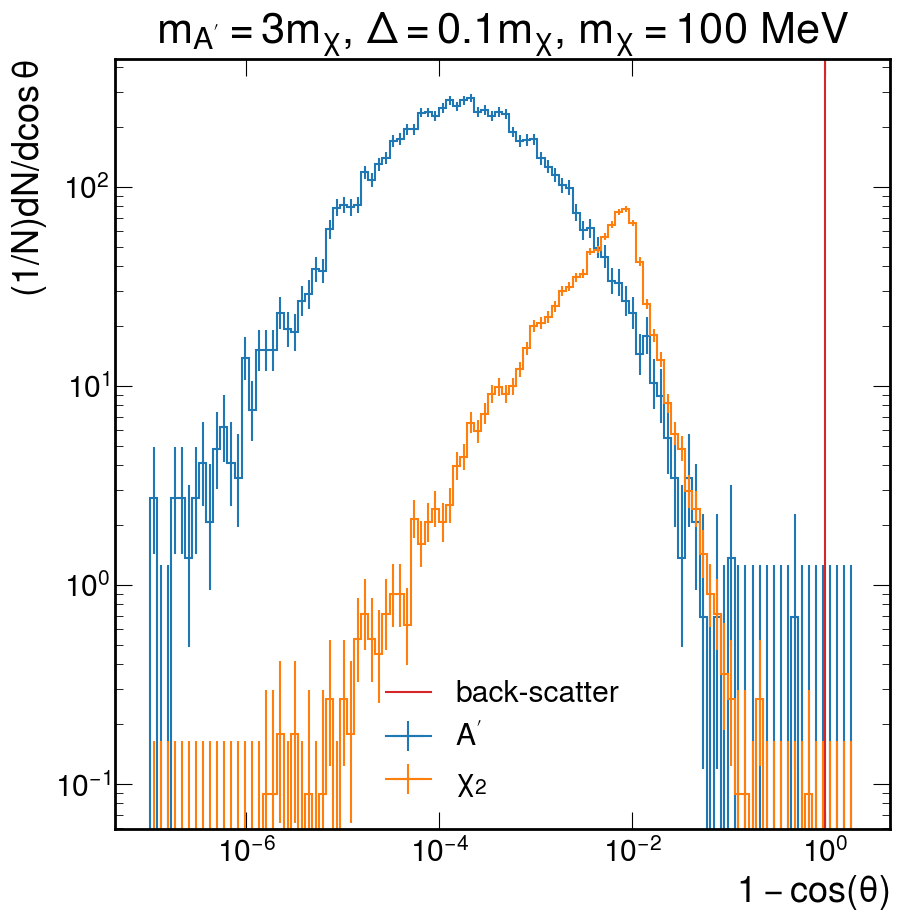

In [52]:
for name, selection in [
    ('$A\'$',(particles['id']==1023)),
    ('$\\chi_2$',(particles['id']==1000023)),
]:
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=1e-7,stop=2, 
            name=f'$1-\cos(\\theta)$',
            transform=hist.axis.transform.log
        ),
    ).fill(
        ak.flatten(
            1-particles[selection]['vector'].costheta
        )
    ).plot(
        label=name,
        density=True
    )

plt.title('$m_{A\'}=3m_\\chi$, $\Delta=0.1m_\\chi$, $m_\\chi = 100$ MeV')
plt.yscale('log')
plt.xscale('log')
#plt.axvline(1-cos(atan(1.5/200)), label='inner border', color='gray')
plt.axvline(1, label='back-scatter', color='tab:red')
plt.legend()
plt.ylabel('$(1/N)dN/d\cos\\theta$')
plt.show()

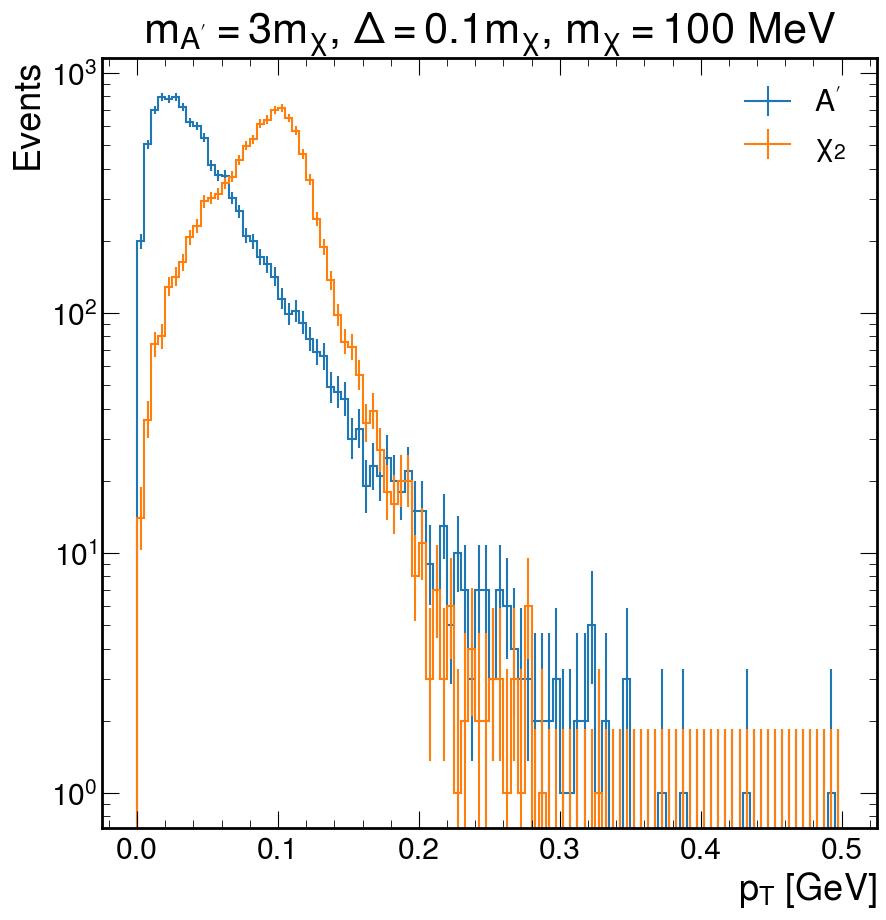

In [53]:
for name, selection in [
    ('$A\'$',(particles['id']==1023)),
    ('$\\chi_2$',(particles['id']==1000023)),
]:
    hist.Hist(
        hist.axis.Regular(
            bins=100,start=0,stop=0.5, 
            name=f'$p_T$ [GeV]'
        ),
    ).fill(
        ak.flatten(
            particles[selection]['vector'].pt
        )
    ).plot(
        label=name
    )

plt.title('$m_{A\'}=3m_\\chi$, $\Delta=0.1m_\\chi$, $m_\\chi = 100$ MeV')
plt.yscale('log')
plt.legend()
plt.ylabel('Events')
plt.show()

## Broader Scan
Also looking at changing values of $m_{A'}$ and $\Delta$.

In [4]:
from pathlib import Path
import pandas as pd

def load_sample(f: Path):
    # f is path to LHE, we are looking for directory
    #  /full/path/to/mchi_<mchi>_rmap_<rmap>_rdmchi_<rdmchi>/lhe/idm_2pt3_<jobid>.lhe
    # get parameters from the directory part 3rd from the end
    params = f.parts[-3].split('_')
    # reformat parameters into look-up table
    params = {params[i]:float(params[i+1]) for i in range(0, len(params), 2)}
    return params, load_pair_momenta(f)

samples = [
    load_sample(f)
    for f in Path('../idm/generator-acceptance/output/HPS-PhysicsRun2016-Pass2').glob('**/*')
    if f.suffix == '.lhe' and f.is_file()
]

In [31]:
import numpy as np
# caculate acceptance fraction for each sample
df = pd.DataFrame({
    'mchi' : np.zeros(len(samples)),
    'rmap' : np.zeros(len(samples)),
    'rdmchi' : np.zeros(len(samples)),
    'acc' : np.zeros(len(samples))
})
df.iloc[0] = (100, 0.1, 0.3, 0.8)
for i, (params, (ele, pos, weights)) in enumerate(samples):
    selection = (ele.E>0.15)&(pos.E>0.15)&(ele.E+pos.E>0.6)&(ele.y/ele.z>0.015)&(pos.y/pos.z>0.015)
    weight_pass=ak.mean(weights[selection])
    num_tota=ak.num(ele, axis=0)
    df.iloc[i] = (*params.values(), weight_pass*(ak.num(selection, axis=0)/num_tota)*10.7/0.01**4)
df

,mchi,rmap,rdmchi,acc
0,30.0,2.0,0.4,75.323399
1,210.0,2.0,0.8,13.128439
2,30.0,5.0,0.4,3.915857
3,210.0,2.0,0.1,NaN
4,180.0,2.0,0.8,28.208688
...,...,...,...,...
58,90.0,5.0,0.8,2.030620
59,150.0,3.0,0.8,23.193866
60,180.0,3.0,0.8,8.519535
61,120.0,5.0,0.1,0.000038


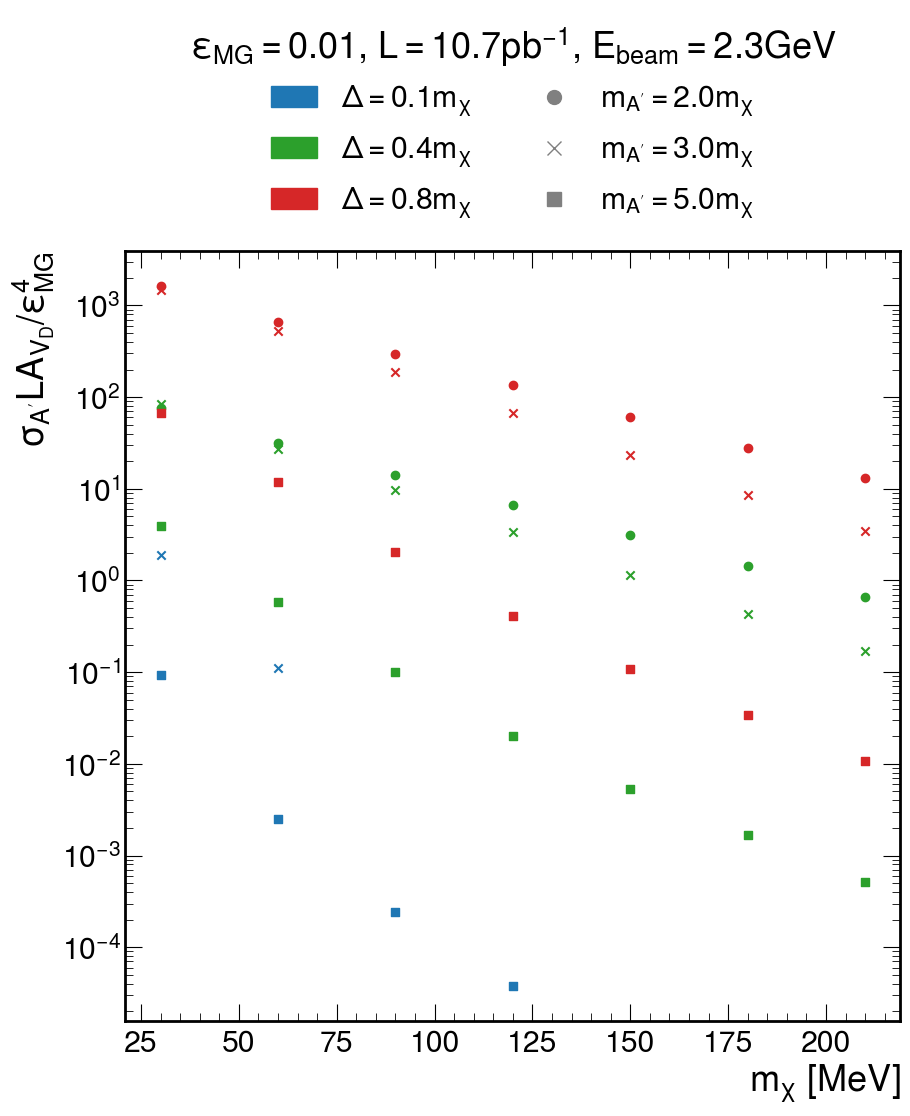

In [33]:
colors = {
    0.1 : 'tab:blue',
    0.4 : 'tab:green',
    0.8 : 'tab:red'
}
markers = {
    2.0 : 'o',
    3.0 : 'x',
    5.0 : 's'
}
for rdmchi, color in colors.items():
    for rmap, marker in markers.items():
        sl=(df['rdmchi']==rdmchi)&(df['rmap']==rmap)
        plt.scatter(
            df[sl]['mchi'],
            df[sl]['acc'],
            color = color,
            marker = marker,
            label=f'$m_{{A\'}}={rmap}m_\\chi$ $\\Delta = {rdmchi}m_\\chi$'
        )

legend_artists = []
for rdmchi, color in colors.items():
    legend_artists.append(
        mpl.patches.Patch(
            facecolor=color, edgecolor=color, 
            label=f'$\\Delta = {rdmchi}m_\\chi$'
        )
    )
for rmap, marker in markers.items():
    legend_artists.append(
        mpl.lines.Line2D(
            [0],[0],
            marker = marker, color='gray', lw=0,
            markersize=10,
            label=f'$m_{{A\'}}={rmap}m_\\chi$'
        )
    )
    
plt.xlabel('$m_\\chi$ [MeV]')
plt.ylabel('$\sigma_{A\'} L A_{V_D} / \\epsilon_\\mathrm{MG}^4$')
plt.legend(
    title='$\\epsilon_\\mathrm{MG}=0.01$, $\\mathcal{L}=10.7\\mathrm{pb}^{-1}$, $E_\\mathrm{beam}=2.3$GeV',
    handles=legend_artists,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5,1.)
)
plt.yscale('log')
plt.savefig('generator-acceptance/plots/acceptance-summary.pdf', bbox_inches='tight')
plt.show()

# Detector Acceptance

In [3]:
import uproot

In [4]:
h = uproot.open('../idm/working/0/h_idm_rot.root')

In [25]:
h.keys()

['event_h;1',
 'mcAna;1',
 'mcAna/mcAna_ele_pxpy_0_hh;1',
 'mcAna/mcAna_ele_pxpy_1000_hh;1',
 'mcAna/mcAna_ele_pxpy_100_hh;1',
 'mcAna/mcAna_ele_pxpy_1100_hh;1',
 'mcAna/mcAna_ele_pxpy_1200_hh;1',
 'mcAna/mcAna_ele_pxpy_1300_hh;1',
 'mcAna/mcAna_ele_pxpy_1400_hh;1',
 'mcAna/mcAna_ele_pxpy_1500_hh;1',
 'mcAna/mcAna_ele_pxpy_1600_hh;1',
 'mcAna/mcAna_ele_pxpy_1700_hh;1',
 'mcAna/mcAna_ele_pxpy_1800_hh;1',
 'mcAna/mcAna_ele_pxpy_1900_hh;1',
 'mcAna/mcAna_ele_pxpy_2000_hh;1',
 'mcAna/mcAna_ele_pxpy_200_hh;1',
 'mcAna/mcAna_ele_pxpy_2100_hh;1',
 'mcAna/mcAna_ele_pxpy_2200_hh;1',
 'mcAna/mcAna_ele_pxpy_2300_hh;1',
 'mcAna/mcAna_ele_pxpy_2400_hh;1',
 'mcAna/mcAna_ele_pxpy_2500_hh;1',
 'mcAna/mcAna_ele_pxpy_2600_hh;1',
 'mcAna/mcAna_ele_pxpy_2700_hh;1',
 'mcAna/mcAna_ele_pxpy_2800_hh;1',
 'mcAna/mcAna_ele_pxpy_2900_hh;1',
 'mcAna/mcAna_ele_pxpy_3000_hh;1',
 'mcAna/mcAna_ele_pxpy_300_hh;1',
 'mcAna/mcAna_ele_pxpy_3100_hh;1',
 'mcAna/mcAna_ele_pxpy_3200_hh;1',
 'mcAna/mcAna_ele_pxpy_3300_hh;1',


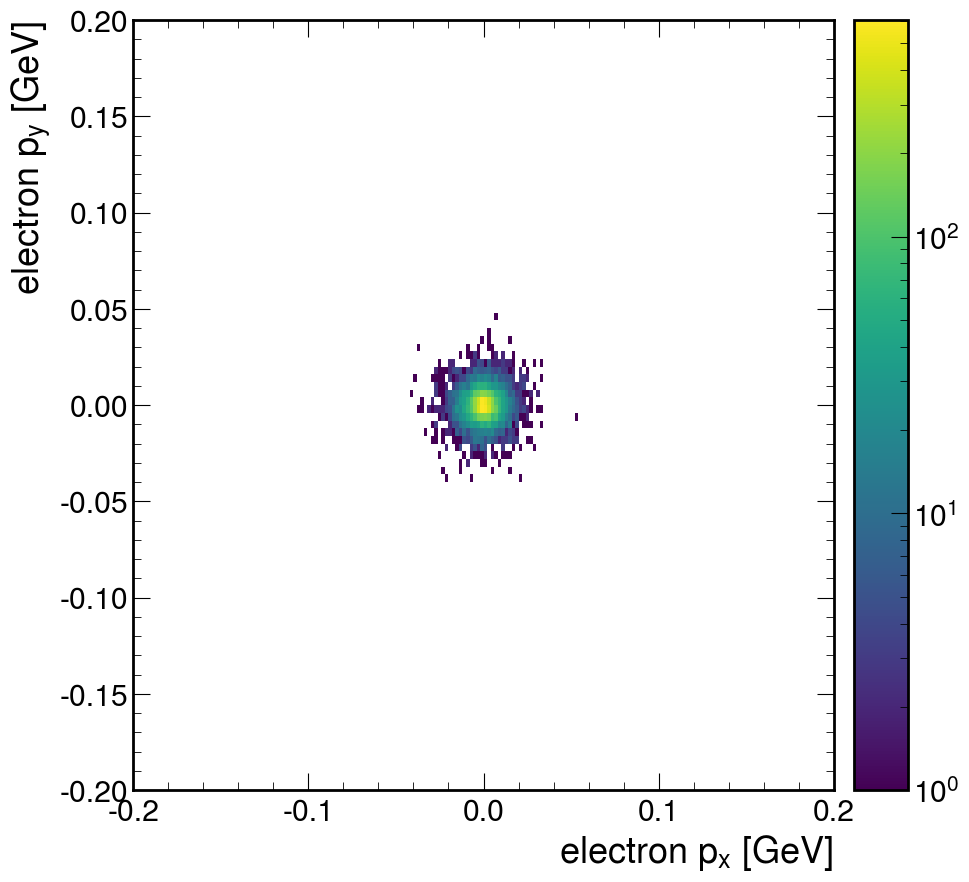

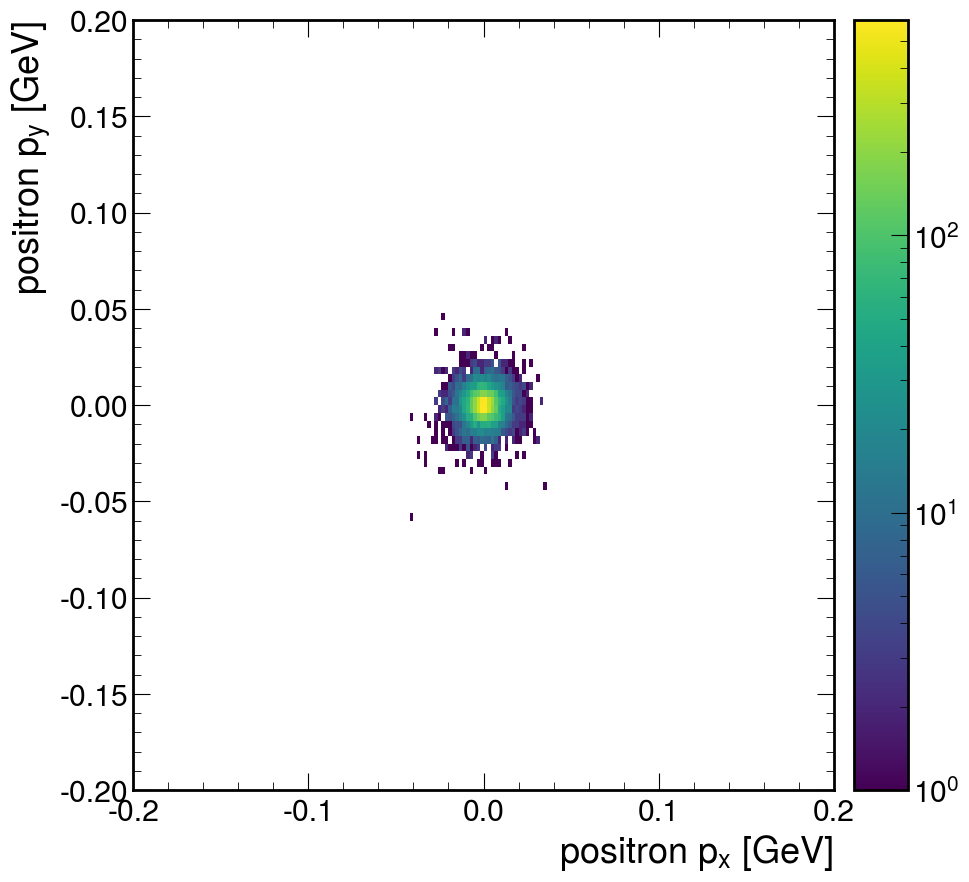

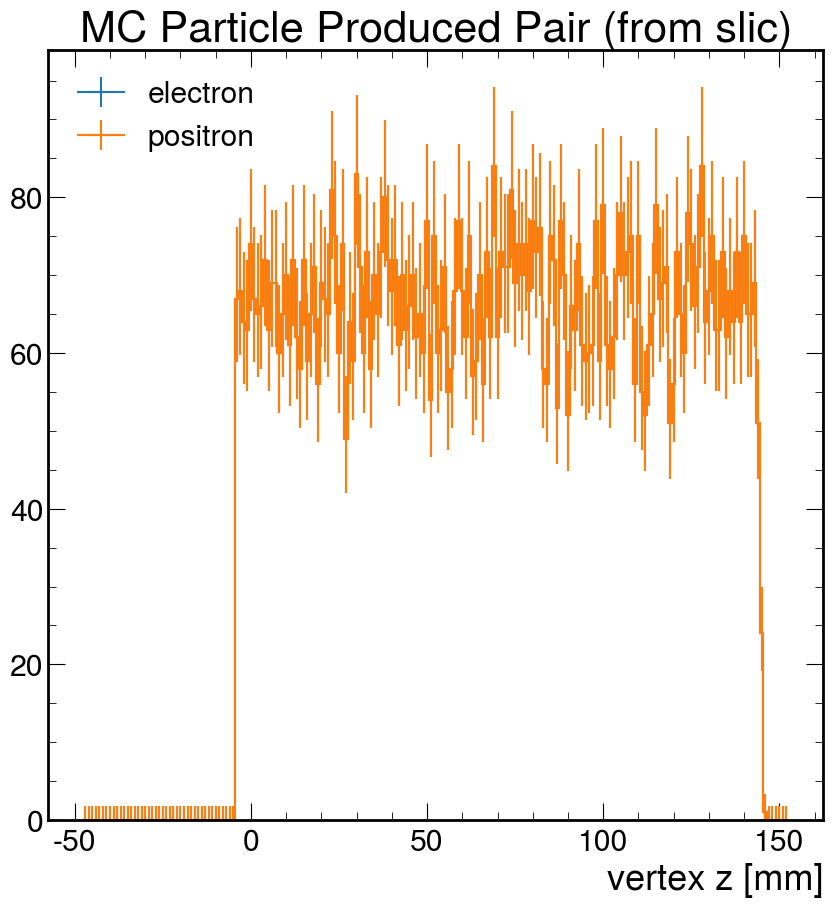

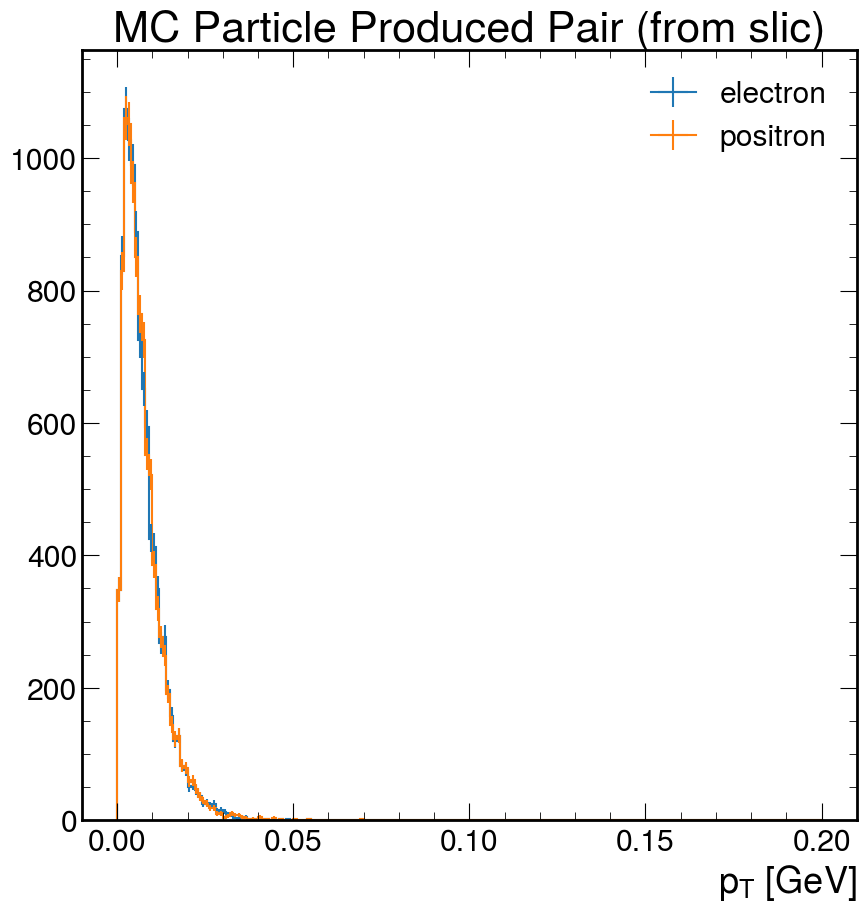

In [29]:
for handle, name in [
    ('ele', 'electron'),
    ('pos', 'positron'),
]:
    h[f'mcAna/mcAna_{handle}_pxpy_hh'].to_hist().plot2d(
        cmin=1,
        norm=mpl.colors.LogNorm()
    )
    plt.xlabel(f'{name} $p_x$ [GeV]')
    plt.ylabel(f'{name} $p_y$ [GeV]')
    plt.show()

for handle, name in [
    ('Elec', 'electron'),
    ('Pos', 'positron')
]:
    h[f'mcAna/mcAna_truthRad{handle}zPos_h'].to_hist().plot1d(
        label = name
    )
plt.xlabel('vertex z [mm]')
plt.title('MC Particle Produced Pair (from slic)')
plt.legend()
plt.show()

for handle, name in [
    ('Elec', 'electron'),
    ('Pos', 'positron')
]:
    h[f'mcAna/mcAna_truthRad{handle}Pt_h'].to_hist().plot1d(
        label = name
    )
plt.xlabel('$p_T$ [GeV]')
plt.title('MC Particle Produced Pair (from slic)')
plt.legend()
plt.show()

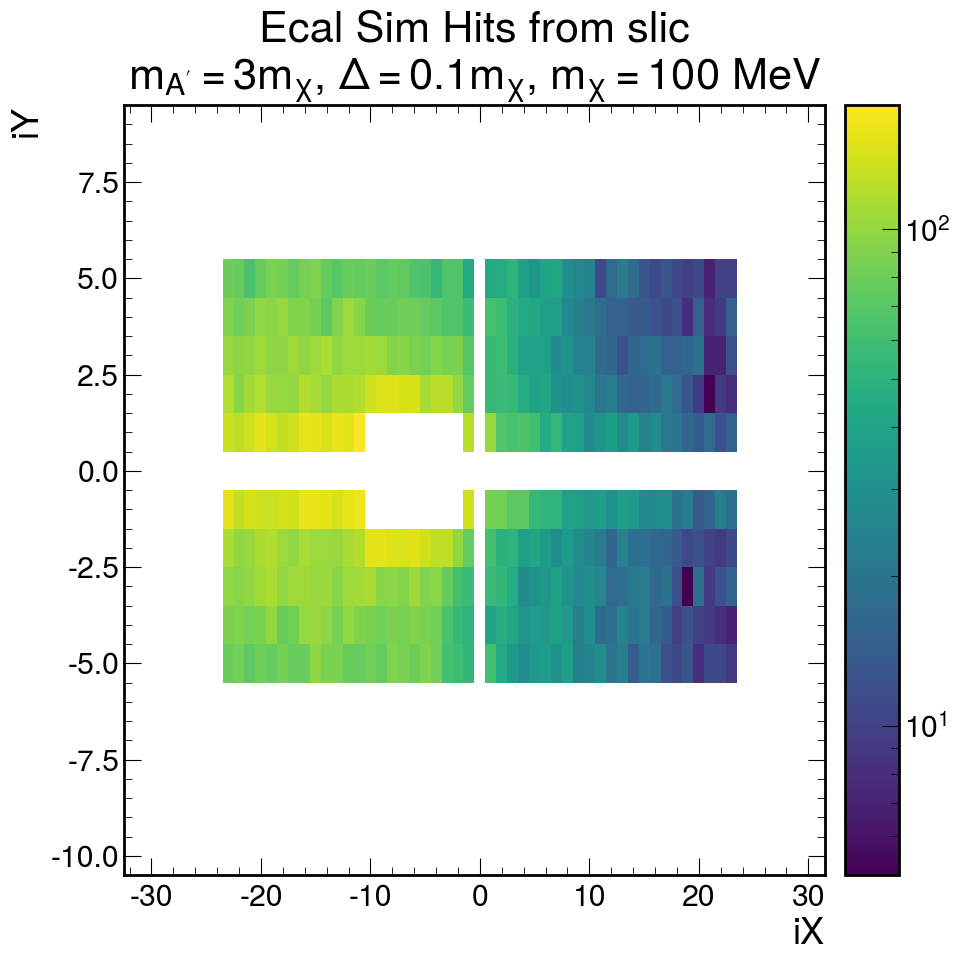

In [30]:
h['mcAna/mcAna_mcEcalHitPos_hh'].to_hist(
)[-32j:32j,-10j:10j].plot2d(
    cmin=1,
    norm=mpl.colors.LogNorm()
)
plt.title("""Ecal Sim Hits from slic
$m_{A'} = 3m_\\chi$, $\Delta=0.1m_\\chi$, $m_\\chi = 100$ MeV""")
plt.xlabel('iX')
plt.ylabel('iY')
plt.show()